## Fasttext, SIF

In [212]:
import datetime, os
import pandas as pd
pd.set_option('display.max.colwidth', 100)
import numpy as np
import gensim
import re
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.spatial.distance import cosine, cdist
from gensim.models import FastText
from gensim.models.callbacks import CallbackAny2Vec
from gensim.test.utils import get_tmpfile
from sklearn.decomposition import TruncatedSVD

In [2]:
class EpochSaver(CallbackAny2Vec):
    '''Callback to save model after each epoch.'''

    def __init__(self, model_dir, path_prefix):
        self.path_prefix = path_prefix
        self.model_dir = model_dir
        self.epoch = 0

    def on_epoch_end(self, model):
        self.epoch += 1
        
    def on_train_end(self, model):
        model.save('{}/{}_epoch{}.model'.format(self.model_dir, self.path_prefix, self.epoch))

class EpochLogger(CallbackAny2Vec):
    '''Callback to print loss after each epoch.'''

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subed = 0

    def on_epoch_end(self, model3):
        loss = model3.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subed
        self.loss_to_be_subed = loss
        print('Loss after epoch {}: {}'.format(self.epoch, loss_now))
        self.epoch += 1

In [213]:
# Smooth Inverse Frequency 
def get_weighted_average(We, x, w):
    """
    Compute the weighted average vectors
    :param We: We[i,:] is the vector for word i
    :param x: x[i, :] are the indices of the words in sentence i
    :param w: w[i, :] are the weights for the words in sentence i
    :return: emb[i, :] are the weighted average vector for sentence i
    """
    n_samples = x.shape[0]
    emb = np.zeros((n_samples, We.shape[1]))
    for i in xrange(n_samples):
        emb[i,:] = w[i,:].dot(We[x[i,:],:]) / np.count_nonzero(w[i,:])
    return emb

def compute_pc(X,npc=1):
    """
    Compute the principal components. DO NOT MAKE THE DATA ZERO MEAN!
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: component_[i,:] is the i-th pc
    """
    svd = TruncatedSVD(n_components=npc, n_iter=7, random_state=0)
    svd.fit(X)
    return svd.components_

def remove_pc(X, npc=1):
    """
    Remove the projection on the principal components
    :param X: X[i,:] is a data point
    :param npc: number of principal components to remove
    :return: XX[i, :] is the data point after removing its projection
    """
    pc = compute_pc(X, npc)
    if npc==1:
        XX = X - X.dot(pc.transpose()) * pc
    else:
        XX = X - X.dot(pc.transpose()).dot(pc)
    return XX

In [3]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
contracts = pd.read_excel("../data/Contracts.xlsx")
outcomes = pd.DataFrame()
titles = pd.DataFrame()
for year in years:
    temp_outcome = pd.read_excel("../data/EXPORT"+str(year)+".xlsx").set_index('관리번호')
    temp_title = pd.read_excel("../data/"+str(year)+".xlsx").set_index('관리번호')
    outcomes = pd.concat([outcomes, temp_outcome], axis=0)
    titles = pd.concat([titles,temp_title], axis=0)

In [4]:
outcomes = pd.concat([outcomes, titles['제목(영어)']], axis=1)
outcomes = outcomes[['예외', '학년도', '성과물구분', '성과물구분명', '기준일', '제목', '제목(영어)', '상위소속명', '소속명', '교직원번호',
       '성명', '관련연구과제', '발송여부', '성과물확인', '교원업적', '자료제출방법', '연동여부(KRI)', '검증여부',
       '전송일시(KRI)', '총저자수']]

In [202]:
outcomes.head()

,예외,학년도,성과물구분,성과물구분명,기준일,제목,제목(영어),상위소속명,소속명,교직원번호,성명,관련연구과제,발송여부,성과물확인,교원업적,자료제출방법,연동여부(KRI),검증여부,전송일시(KRI),총저자수
관리번호,,,,,,,,,,,,,,,,,,,,
20646,NaN,2015,1,논문,2015-05-30,YouTube acceptance by university educators and...,YouTube acceptance by university educators and...,특수대학원,교육대학원,111217,이예경,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21054,NaN,2015,1,논문,2015-10-01,Emotional information processing based on feat...,Emotional information processing based on feat...,공학부,컴퓨터공학전공,101623,김지환,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21110,NaN,2015,1,논문,2015-04-01,Controller Design for Mechanical Impedance Red...,Controller Design for Mechanical Impedance Red...,공학부,기계공학전공,111847,공경철,201431009.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2
21597,NaN,2015,1,논문,2015-05-01,Perceived stigma of alcohol dependency: compar...,Perceived stigma of alcohol dependency: compar...,전문대학원,경영전문대학원,101434,신호창,NaN,예,예,예,파일제출(파일업로드),False,검증완료,NaN,3
21636,NaN,2015,1,논문,2015-12-21,Multisensory fashion communication media towar...,Multisensory fashion communication media towar...,전문대학원,영상대학원,113308,최용순,201310044.0,예,예,예,파일제출(파일업로드),False,검증완료,NaN,2


In [5]:
inventions = outcomes.iloc[~np.isin(outcomes['성과물구분명'],['저서','수상','창작','기술이전'])]
title_inv = inventions['제목(영어)'].drop_duplicates(keep='first')

In [6]:
outcomes_tech = outcomes[outcomes['성과물구분명']=='기술이전']
title_tech = []
index_tech = []
technologies = []
for i in tqdm(range(len(outcomes_tech))):
    if outcomes_tech.iloc[i]['제목'] in list(contracts['계약명칭']):
#         print(outcomes_tech.iloc[i]['성명'], contracts.iloc[list(contracts['계약명칭']).index(outcomes_tech.iloc[i]['제목'])]['책임발명자'])
        title_tech.append(outcomes_tech.iloc[i]['제목(영어)'])
        index_tech.append(outcomes_tech.iloc[i].name)
        index_contract = contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.iloc[i]['제목']).notna()].index[0]
        technologies.append(pd.concat([pd.Series(outcomes_tech.iloc[i].name).rename({0: "관리번호"}), pd.Series(outcomes_tech.iloc[i]['제목(영어)']).rename({0: "제목"}), contracts.loc[contracts['계약명칭'][contracts['계약명칭'].where(contracts['계약명칭']==outcomes_tech.iloc[i]['제목']).notna()].index[0]]]))
title_tech = pd.Series(title_tech, index=index_tech).drop_duplicates(keep='first')
technologies = pd.concat(technologies, axis=1).T
technologies = technologies.drop(technologies['학과'][technologies['학과'].isna()].index)

100%|██████████| 631/631 [00:05<00:00, 123.41it/s]


In [7]:
name_idx = pd.Series(np.union1d(technologies['책임발명자'].unique(), inventions['성명'].unique()))
idx_name = pd.Series(name_idx.index, index=list(name_idx))
depart_idx = pd.Series(np.union1d(technologies['학과'].unique().astype('str')[technologies['학과'].unique().astype('str')!='nan'], inventions['소속명'].unique()))
idx_depart = pd.Series(depart_idx.index, index=list(depart_idx))
use_cols_inv = ['성과물구분명', '기준일', '제목(영어)', '소속명', 'depart_idx', '성명', 'name_idx']
use_cols_tech = ['관리번호', '기술구분', '계약일', '제목', '학과', 'depart_idx', '책임발명자', 'name_idx']

In [8]:
inventions = outcomes.iloc[~np.isin(outcomes['성과물구분명'],['저서','수상','창작','기술이전'])]
inventions = pd.concat([inventions, pd.Series(map(lambda x: idx_name.loc[x], list(inventions['성명'])), index=inventions.index).rename("name_idx"), pd.Series(map(lambda x: idx_depart.loc[x], list(inventions['소속명'])), index=inventions.index).rename("depart_idx")], axis=1)[use_cols_inv]
inventions = inventions.rename({'제목(영어)': 'title', '소속명': 'department', '성명': 'name', '기준일': 'date', '성과물구분명': 'type'}, axis=1)
inventions.index.name = 'inv_no'
title_inv = inventions['title'].drop_duplicates(keep='first')
inventions = inventions.loc[title_inv.index]

In [9]:
technologies = pd.concat([technologies, pd.Series(map(lambda x: idx_name.loc[x], list(technologies['책임발명자'])), index=technologies.index).rename("name_idx"), pd.Series(map(lambda x: idx_depart.loc[x], list(technologies['학과'])), index=technologies.index).rename("depart_idx")], axis=1)[use_cols_tech]
technologies = technologies.rename({'관리번호': 'tech_no', '기술구분': 'type', '계약일': 'date', '제목': 'title', '학과': 'department', '책임발명자': 'name'}, axis=1)
technologies = technologies.set_index('tech_no')

In [203]:
inventions.head()

,type,date,title,department,depart_idx,name,name_idx
inv_no,,,,,,,
20646,논문,2015-05-30,YouTube acceptance by university educators and...,교육대학원,8,이예경,398
21054,논문,2015-10-01,Emotional information processing based on feat...,컴퓨터공학전공,60,김지환,150
21110,논문,2015-04-01,Controller Design for Mechanical Impedance Red...,기계공학전공,14,공경철,53
21597,논문,2015-05-01,Perceived stigma of alcohol dependency: compar...,경영전문대학원,2,신호창,292
21636,논문,2015-12-21,Multisensory fashion communication media towar...,영상대학원,49,최용순,575


In [204]:
technologies.head()

,type,date,title,department,depart_idx,name,name_idx
tech_no,,,,,,,
5000000737,Know-How,2015-01-30 00:00:00,Know-how to develop high-speed signal interfac...,전자공학전공,53,범진욱,246
5000000739,Know-How,2015-03-01 00:00:00,12b low-power SAR-type ADC IP(3종),전자공학전공,53,이승훈,394
5000000740,Know-How,2015-03-27 00:00:00,Improving image sensor design capabilities and...,전자공학전공,53,최희철,591
5000000741,Know-How,2015-08-04 00:00:00,"Transfer know-how - fluid with Phase Change, H...",기계공학전공,14,손기헌,268
5000000751,Know-How,2015-08-03 00:00:00,Know-how technology transfer for technology se...,컴퓨터공학전공,60,박운상,224


In [205]:
index_inv = title_inv.index
index_tech = title_tech.index
print("#research: {}, #technology: {}".format(len(inventions), len(technologies)))

#research: 16517, #technology: 565


In [419]:
def extract_word(text):
    word_list = re.findall('[a-zA-Z0-9\-\__]+', text)
    return word_list

def calc_vec(model, title_list, method='avg', list_total=None, alpha=1e-3):
    out_vec = []
    if method in ['sif', 'sif_weight']:
        words_unq, words_weights = np.unique(list_total, return_counts=True)
        if method=='sif_weight':
            words_weights = words_weights / len(list_total)
            words_weights = alpha / (alpha + words_weights)
        else:
            words_weights = words_weights / len(list_total)
    for word_list in tqdm(title_list):
        if method=='avg':
            sentence_vec = [model.wv[word] for word in word_list]
            out_vec.append(np.mean(sentence_vec, axis=0))
        elif method=='sum':
            sentence_vec = [model.wv[word] for word in word_list]
            out_vec.append(np.sum(sentence_vec, axis=0))
        elif method=='sif':
            wv_s = np.array([model.wv[word] for word in word_list])
            sentence_vec = np.array([model.wv[word] for word in word_list])
            out_vec.append(np.mean(sentence_vec, axis=0))
        elif method=='sif_weight':
            ww_s = np.array([words_weights[np.where(words_unq==word)[0][0]] for word in word_list])
            wv_s = np.array([model.wv[word] for word in word_list])
            sentence_vec = ww_s.dot(wv_s) / np.count_nonzero(ww_s)
            out_vec.append(sentence_vec)
    if method in ['sif', 'sif_weight']:
        out_vec = np.array(out_vec)
        out_vec = list(remove_pc(out_vec, 1))
    return pd.Series(out_vec, index=title_list.index)

def get_loc(df, index):
    return df.index[index]

def get_iloc(df, index):
    return list(df.index).index(index)

def calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=5):
    index_inv = title_inv.index
    index_tech = title_tech.index
    dist_list = cdist(np.concatenate((list(vec_tech))).reshape(len(vec_tech), -1), np.concatenate((list(vec_inv))).reshape(len(vec_inv), -1), 'cosine')
    top_candidates = {}
    for id_target in tqdm(vec_tech.index):
        top_candidates[id_target] = {}
        iloc_target = get_iloc(vec_tech, id_target)
        top_invention = inventions.loc[index_inv[np.argsort(dist_list[iloc_target])]]['name'].drop_duplicates(keep='first')[:topk].index
        top_candidates[id_target]['title'] = inventions.loc[top_invention]['title']
        top_candidates[id_target]['inventor'] = inventions.loc[top_invention]['name']
        top_candidates[id_target]['department'] = inventions.loc[top_invention]['department']
        top_candidates[id_target]['inventor_idx'] = inventions.loc[top_invention]['name_idx']
        top_candidates[id_target]['department_idx'] = inventions.loc[top_invention]['depart_idx']
        top_candidates[id_target]['distance'] = pd.Series(dist_list[iloc_target], index=vec_inv.index).loc[top_invention]
    return top_candidates

In [12]:
list_inv = pd.Series(list(map(extract_word, title_inv)), index=index_inv)
list_tech = pd.Series(list(map(extract_word, title_tech)), index=index_tech)
list_total = sum((list(list_tech)+list(list_inv)), [])
sentences_to_train = list(pd.concat([list_inv, list_tech]))

In [479]:
MODEL_DIR="../models"

model_type_to_load = input("Want to load FastText model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): ")
if model_type_to_load in ['1', 'load_pretrained']:
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = gensim.models.fasttext.load_facebook_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))
    pretrained_model = copy.copy(ft_model)
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['2', 'load_additional']:
    available_epochs = []
    for fname in os.listdir(MODEL_DIR):
        if "Tech_licensing_transfer_epoch" in fname and ".npy" not in fname:
            available_epochs.append(fname.split("epoch")[-1].replace(".model",""))
    print("Available number of epochs:",available_epochs)    
    n_epochs = input("#epochs: ")
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = FastText.load(os.path.join(MODEL_DIR, "Tech_licensing_transfer_epoch"+str(n_epochs)+".model"))
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Tech_licensing_transfer_epoch"+str(n_epochs)+" is loaded")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['3', 'load_new']:
    available_epochs = []
    for fname in os.listdir(MODEL_DIR):
        if "Tech_licensing_new_epoch" in fname and ".npy" not in fname:
            available_epochs.append(fname.split("epoch")[-1].replace(".model",""))
    print("Available number of epochs:",available_epochs)
    n_epochs = input("#epochs: ")
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = FastText.load(os.path.join(MODEL_DIR, "Tech_licensing_new_epoch"+str(n_epochs)+".model"))
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Tech_licensing_additional_epoch"+str(n_epochs)+" is loaded")
    print("Vocab size",len(ft_model.wv.key_to_index))
elif model_type_to_load in ['4', 'train_transfer']:
    n_epochs = input("#epochs: ")
    n_epochs = int(n_epochs)
    print(f"== LOAD fasttext model START at {datetime.datetime.now()}")
    ft_model = gensim.models.fasttext.load_facebook_model(os.path.join(MODEL_DIR, 'cc.en.300.bin'))
    pretrained_model = copy.copy(ft_model)
    print(f"== LOAD fasttext model END at {datetime.datetime.now()}")
    print("Before building vocab with additional sentences,",len(ft_model.wv.key_to_index))
    print(f"== BUILD vocab START at {datetime.datetime.now()}")
    ft_model.build_vocab(sentences_to_train, update=True, keep_raw_vocab=True)
    print(f"== BUILD vocab END at {datetime.datetime.now()}")
    print("After building vocab with additional sentences,",len(ft_model.wv.key_to_index))
    
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_additional')
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train, 
                   total_examples=len(sentences_to_train),
                   epochs=n_epochs,
                   compute_loss=True,
                   callbacks=[epoch_saver, epoch_logger]
                  )
elif model_type_to_load in ['5', 'train_new']:
    n_epochs = input("#epochs: ")
    n_epochs = int(n_epochs)
    vector_size = input("Vector size: ")
    vector_size = int(vector_size)
    ft_model = FastText(min_count=0, sg=1, vector_size=vector_size)
    ft_model.build_vocab(sentences_to_train)
    print("Vocab size",len(ft_model.wv.key_to_index))
    epoch_saver = EpochSaver(model_dir=MODEL_DIR, path_prefix='Tech_licensing_new')
    epoch_logger = EpochLogger()
    ft_model.train(corpus_iterable=sentences_to_train,
           total_examples=len(sentences_to_train),
           epochs=n_epochs,
           compute_loss=False,
           callbacks=[epoch_saver, epoch_logger])

Want to load FastText model? (1. load_pretrained, 2. load_transfer, 3. load_new, 4. train_transfer, 5. train_new): 4
#epochs: 10000
== LOAD fasttext model START at 2022-03-21 10:19:26.140206
== LOAD fasttext model END at 2022-03-21 10:22:51.407349
Before building vocab with additional sentences, 2000000
== BUILD vocab START at 2022-03-21 10:22:51.408175
== BUILD vocab END at 2022-03-21 10:24:16.402501
After building vocab with additional sentences, 2000101
Loss after epoch 0: 0.0
Loss after epoch 1: 0.0
Loss after epoch 2: 0.0
Loss after epoch 3: 0.0
Loss after epoch 4: 0.0
Loss after epoch 5: 0.0
Loss after epoch 6: 0.0
Loss after epoch 7: 0.0
Loss after epoch 8: 0.0
Loss after epoch 9: 0.0
Loss after epoch 10: 0.0
Loss after epoch 11: 0.0
Loss after epoch 12: 0.0
Loss after epoch 13: 0.0
Loss after epoch 14: 0.0
Loss after epoch 15: 0.0
Loss after epoch 16: 0.0
Loss after epoch 17: 0.0
Loss after epoch 18: 0.0
Loss after epoch 19: 0.0
Loss after epoch 20: 0.0
Loss after epoch 21: 0.0

Loss after epoch 302: 0.0
Loss after epoch 303: 0.0
Loss after epoch 304: 0.0
Loss after epoch 305: 0.0
Loss after epoch 306: 0.0
Loss after epoch 307: 0.0
Loss after epoch 308: 0.0
Loss after epoch 309: 0.0
Loss after epoch 310: 0.0
Loss after epoch 311: 0.0
Loss after epoch 312: 0.0
Loss after epoch 313: 0.0
Loss after epoch 314: 0.0
Loss after epoch 315: 0.0
Loss after epoch 316: 0.0
Loss after epoch 317: 0.0
Loss after epoch 318: 0.0
Loss after epoch 319: 0.0
Loss after epoch 320: 0.0
Loss after epoch 321: 0.0
Loss after epoch 322: 0.0
Loss after epoch 323: 0.0
Loss after epoch 324: 0.0
Loss after epoch 325: 0.0
Loss after epoch 326: 0.0
Loss after epoch 327: 0.0
Loss after epoch 328: 0.0
Loss after epoch 329: 0.0
Loss after epoch 330: 0.0
Loss after epoch 331: 0.0
Loss after epoch 332: 0.0
Loss after epoch 333: 0.0
Loss after epoch 334: 0.0
Loss after epoch 335: 0.0
Loss after epoch 336: 0.0
Loss after epoch 337: 0.0
Loss after epoch 338: 0.0
Loss after epoch 339: 0.0
Loss after e

Loss after epoch 618: 0.0
Loss after epoch 619: 0.0
Loss after epoch 620: 0.0
Loss after epoch 621: 0.0
Loss after epoch 622: 0.0
Loss after epoch 623: 0.0
Loss after epoch 624: 0.0
Loss after epoch 625: 0.0
Loss after epoch 626: 0.0
Loss after epoch 627: 0.0
Loss after epoch 628: 0.0
Loss after epoch 629: 0.0
Loss after epoch 630: 0.0
Loss after epoch 631: 0.0
Loss after epoch 632: 0.0
Loss after epoch 633: 0.0
Loss after epoch 634: 0.0
Loss after epoch 635: 0.0
Loss after epoch 636: 0.0
Loss after epoch 637: 0.0
Loss after epoch 638: 0.0
Loss after epoch 639: 0.0
Loss after epoch 640: 0.0
Loss after epoch 641: 0.0
Loss after epoch 642: 0.0
Loss after epoch 643: 0.0
Loss after epoch 644: 0.0
Loss after epoch 645: 0.0
Loss after epoch 646: 0.0
Loss after epoch 647: 0.0
Loss after epoch 648: 0.0
Loss after epoch 649: 0.0
Loss after epoch 650: 0.0
Loss after epoch 651: 0.0
Loss after epoch 652: 0.0
Loss after epoch 653: 0.0
Loss after epoch 654: 0.0
Loss after epoch 655: 0.0
Loss after e

Loss after epoch 934: 0.0
Loss after epoch 935: 0.0
Loss after epoch 936: 0.0
Loss after epoch 937: 0.0
Loss after epoch 938: 0.0
Loss after epoch 939: 0.0
Loss after epoch 940: 0.0
Loss after epoch 941: 0.0
Loss after epoch 942: 0.0
Loss after epoch 943: 0.0
Loss after epoch 944: 0.0
Loss after epoch 945: 0.0
Loss after epoch 946: 0.0
Loss after epoch 947: 0.0
Loss after epoch 948: 0.0
Loss after epoch 949: 0.0
Loss after epoch 950: 0.0
Loss after epoch 951: 0.0
Loss after epoch 952: 0.0
Loss after epoch 953: 0.0
Loss after epoch 954: 0.0
Loss after epoch 955: 0.0
Loss after epoch 956: 0.0
Loss after epoch 957: 0.0
Loss after epoch 958: 0.0
Loss after epoch 959: 0.0
Loss after epoch 960: 0.0
Loss after epoch 961: 0.0
Loss after epoch 962: 0.0
Loss after epoch 963: 0.0
Loss after epoch 964: 0.0
Loss after epoch 965: 0.0
Loss after epoch 966: 0.0
Loss after epoch 967: 0.0
Loss after epoch 968: 0.0
Loss after epoch 969: 0.0
Loss after epoch 970: 0.0
Loss after epoch 971: 0.0
Loss after e

Loss after epoch 1240: 0.0
Loss after epoch 1241: 0.0
Loss after epoch 1242: 0.0
Loss after epoch 1243: 0.0
Loss after epoch 1244: 0.0
Loss after epoch 1245: 0.0
Loss after epoch 1246: 0.0
Loss after epoch 1247: 0.0
Loss after epoch 1248: 0.0
Loss after epoch 1249: 0.0
Loss after epoch 1250: 0.0
Loss after epoch 1251: 0.0
Loss after epoch 1252: 0.0
Loss after epoch 1253: 0.0
Loss after epoch 1254: 0.0
Loss after epoch 1255: 0.0
Loss after epoch 1256: 0.0
Loss after epoch 1257: 0.0
Loss after epoch 1258: 0.0
Loss after epoch 1259: 0.0
Loss after epoch 1260: 0.0
Loss after epoch 1261: 0.0
Loss after epoch 1262: 0.0
Loss after epoch 1263: 0.0
Loss after epoch 1264: 0.0
Loss after epoch 1265: 0.0
Loss after epoch 1266: 0.0
Loss after epoch 1267: 0.0
Loss after epoch 1268: 0.0
Loss after epoch 1269: 0.0
Loss after epoch 1270: 0.0
Loss after epoch 1271: 0.0
Loss after epoch 1272: 0.0
Loss after epoch 1273: 0.0
Loss after epoch 1274: 0.0
Loss after epoch 1275: 0.0
Loss after epoch 1276: 0.0
L

Loss after epoch 1544: 0.0
Loss after epoch 1545: 0.0
Loss after epoch 1546: 0.0
Loss after epoch 1547: 0.0
Loss after epoch 1548: 0.0
Loss after epoch 1549: 0.0
Loss after epoch 1550: 0.0
Loss after epoch 1551: 0.0
Loss after epoch 1552: 0.0
Loss after epoch 1553: 0.0
Loss after epoch 1554: 0.0
Loss after epoch 1555: 0.0
Loss after epoch 1556: 0.0
Loss after epoch 1557: 0.0
Loss after epoch 1558: 0.0
Loss after epoch 1559: 0.0
Loss after epoch 1560: 0.0
Loss after epoch 1561: 0.0
Loss after epoch 1562: 0.0
Loss after epoch 1563: 0.0
Loss after epoch 1564: 0.0
Loss after epoch 1565: 0.0
Loss after epoch 1566: 0.0
Loss after epoch 1567: 0.0
Loss after epoch 1568: 0.0
Loss after epoch 1569: 0.0
Loss after epoch 1570: 0.0
Loss after epoch 1571: 0.0
Loss after epoch 1572: 0.0
Loss after epoch 1573: 0.0
Loss after epoch 1574: 0.0
Loss after epoch 1575: 0.0
Loss after epoch 1576: 0.0
Loss after epoch 1577: 0.0
Loss after epoch 1578: 0.0
Loss after epoch 1579: 0.0
Loss after epoch 1580: 0.0
L

Loss after epoch 1848: 0.0
Loss after epoch 1849: 0.0
Loss after epoch 1850: 0.0
Loss after epoch 1851: 0.0
Loss after epoch 1852: 0.0
Loss after epoch 1853: 0.0
Loss after epoch 1854: 0.0
Loss after epoch 1855: 0.0
Loss after epoch 1856: 0.0
Loss after epoch 1857: 0.0
Loss after epoch 1858: 0.0
Loss after epoch 1859: 0.0
Loss after epoch 1860: 0.0
Loss after epoch 1861: 0.0
Loss after epoch 1862: 0.0
Loss after epoch 1863: 0.0
Loss after epoch 1864: 0.0
Loss after epoch 1865: 0.0
Loss after epoch 1866: 0.0
Loss after epoch 1867: 0.0
Loss after epoch 1868: 0.0
Loss after epoch 1869: 0.0
Loss after epoch 1870: 0.0
Loss after epoch 1871: 0.0
Loss after epoch 1872: 0.0
Loss after epoch 1873: 0.0
Loss after epoch 1874: 0.0
Loss after epoch 1875: 0.0
Loss after epoch 1876: 0.0
Loss after epoch 1877: 0.0
Loss after epoch 1878: 0.0
Loss after epoch 1879: 0.0
Loss after epoch 1880: 0.0
Loss after epoch 1881: 0.0
Loss after epoch 1882: 0.0
Loss after epoch 1883: 0.0
Loss after epoch 1884: 0.0
L

Loss after epoch 2152: 0.0
Loss after epoch 2153: 0.0
Loss after epoch 2154: 0.0
Loss after epoch 2155: 0.0
Loss after epoch 2156: 0.0
Loss after epoch 2157: 0.0
Loss after epoch 2158: 0.0
Loss after epoch 2159: 0.0
Loss after epoch 2160: 0.0
Loss after epoch 2161: 0.0
Loss after epoch 2162: 0.0
Loss after epoch 2163: 0.0
Loss after epoch 2164: 0.0
Loss after epoch 2165: 0.0
Loss after epoch 2166: 0.0
Loss after epoch 2167: 0.0
Loss after epoch 2168: 0.0
Loss after epoch 2169: 0.0
Loss after epoch 2170: 0.0
Loss after epoch 2171: 0.0
Loss after epoch 2172: 0.0
Loss after epoch 2173: 0.0
Loss after epoch 2174: 0.0
Loss after epoch 2175: 0.0
Loss after epoch 2176: 0.0
Loss after epoch 2177: 0.0
Loss after epoch 2178: 0.0
Loss after epoch 2179: 0.0
Loss after epoch 2180: 0.0
Loss after epoch 2181: 0.0
Loss after epoch 2182: 0.0
Loss after epoch 2183: 0.0
Loss after epoch 2184: 0.0
Loss after epoch 2185: 0.0
Loss after epoch 2186: 0.0
Loss after epoch 2187: 0.0
Loss after epoch 2188: 0.0
L

Loss after epoch 2456: 0.0
Loss after epoch 2457: 0.0
Loss after epoch 2458: 0.0
Loss after epoch 2459: 0.0
Loss after epoch 2460: 0.0
Loss after epoch 2461: 0.0
Loss after epoch 2462: 0.0
Loss after epoch 2463: 0.0
Loss after epoch 2464: 0.0
Loss after epoch 2465: 0.0
Loss after epoch 2466: 0.0
Loss after epoch 2467: 0.0
Loss after epoch 2468: 0.0
Loss after epoch 2469: 0.0
Loss after epoch 2470: 0.0
Loss after epoch 2471: 0.0
Loss after epoch 2472: 0.0
Loss after epoch 2473: 0.0
Loss after epoch 2474: 0.0
Loss after epoch 2475: 0.0
Loss after epoch 2476: 0.0
Loss after epoch 2477: 0.0
Loss after epoch 2478: 0.0
Loss after epoch 2479: 0.0
Loss after epoch 2480: 0.0
Loss after epoch 2481: 0.0
Loss after epoch 2482: 0.0
Loss after epoch 2483: 0.0
Loss after epoch 2484: 0.0
Loss after epoch 2485: 0.0
Loss after epoch 2486: 0.0
Loss after epoch 2487: 0.0
Loss after epoch 2488: 0.0
Loss after epoch 2489: 0.0
Loss after epoch 2490: 0.0
Loss after epoch 2491: 0.0
Loss after epoch 2492: 0.0
L

Loss after epoch 2760: 0.0
Loss after epoch 2761: 0.0
Loss after epoch 2762: 0.0
Loss after epoch 2763: 0.0
Loss after epoch 2764: 0.0
Loss after epoch 2765: 0.0
Loss after epoch 2766: 0.0
Loss after epoch 2767: 0.0
Loss after epoch 2768: 0.0
Loss after epoch 2769: 0.0
Loss after epoch 2770: 0.0
Loss after epoch 2771: 0.0
Loss after epoch 2772: 0.0
Loss after epoch 2773: 0.0
Loss after epoch 2774: 0.0
Loss after epoch 2775: 0.0
Loss after epoch 2776: 0.0
Loss after epoch 2777: 0.0
Loss after epoch 2778: 0.0
Loss after epoch 2779: 0.0
Loss after epoch 2780: 0.0
Loss after epoch 2781: 0.0
Loss after epoch 2782: 0.0
Loss after epoch 2783: 0.0
Loss after epoch 2784: 0.0
Loss after epoch 2785: 0.0
Loss after epoch 2786: 0.0
Loss after epoch 2787: 0.0
Loss after epoch 2788: 0.0
Loss after epoch 2789: 0.0
Loss after epoch 2790: 0.0
Loss after epoch 2791: 0.0
Loss after epoch 2792: 0.0
Loss after epoch 2793: 0.0
Loss after epoch 2794: 0.0
Loss after epoch 2795: 0.0
Loss after epoch 2796: 0.0
L

Loss after epoch 3064: 0.0
Loss after epoch 3065: 0.0
Loss after epoch 3066: 0.0
Loss after epoch 3067: 0.0
Loss after epoch 3068: 0.0
Loss after epoch 3069: 0.0
Loss after epoch 3070: 0.0
Loss after epoch 3071: 0.0
Loss after epoch 3072: 0.0
Loss after epoch 3073: 0.0
Loss after epoch 3074: 0.0
Loss after epoch 3075: 0.0
Loss after epoch 3076: 0.0
Loss after epoch 3077: 0.0
Loss after epoch 3078: 0.0
Loss after epoch 3079: 0.0
Loss after epoch 3080: 0.0
Loss after epoch 3081: 0.0
Loss after epoch 3082: 0.0
Loss after epoch 3083: 0.0
Loss after epoch 3084: 0.0
Loss after epoch 3085: 0.0
Loss after epoch 3086: 0.0
Loss after epoch 3087: 0.0
Loss after epoch 3088: 0.0
Loss after epoch 3089: 0.0
Loss after epoch 3090: 0.0
Loss after epoch 3091: 0.0
Loss after epoch 3092: 0.0
Loss after epoch 3093: 0.0
Loss after epoch 3094: 0.0
Loss after epoch 3095: 0.0
Loss after epoch 3096: 0.0
Loss after epoch 3097: 0.0
Loss after epoch 3098: 0.0
Loss after epoch 3099: 0.0
Loss after epoch 3100: 0.0
L

Loss after epoch 3368: 0.0
Loss after epoch 3369: 0.0
Loss after epoch 3370: 0.0
Loss after epoch 3371: 0.0
Loss after epoch 3372: 0.0
Loss after epoch 3373: 0.0
Loss after epoch 3374: 0.0
Loss after epoch 3375: 0.0
Loss after epoch 3376: 0.0
Loss after epoch 3377: 0.0
Loss after epoch 3378: 0.0
Loss after epoch 3379: 0.0
Loss after epoch 3380: 0.0
Loss after epoch 3381: 0.0
Loss after epoch 3382: 0.0
Loss after epoch 3383: 0.0
Loss after epoch 3384: 0.0
Loss after epoch 3385: 0.0
Loss after epoch 3386: 0.0
Loss after epoch 3387: 0.0
Loss after epoch 3388: 0.0
Loss after epoch 3389: 0.0
Loss after epoch 3390: 0.0
Loss after epoch 3391: 0.0
Loss after epoch 3392: 0.0
Loss after epoch 3393: 0.0
Loss after epoch 3394: 0.0
Loss after epoch 3395: 0.0
Loss after epoch 3396: 0.0
Loss after epoch 3397: 0.0
Loss after epoch 3398: 0.0
Loss after epoch 3399: 0.0
Loss after epoch 3400: 0.0
Loss after epoch 3401: 0.0
Loss after epoch 3402: 0.0
Loss after epoch 3403: 0.0
Loss after epoch 3404: 0.0
L

Loss after epoch 3672: 0.0
Loss after epoch 3673: 0.0
Loss after epoch 3674: 0.0
Loss after epoch 3675: 0.0
Loss after epoch 3676: 0.0
Loss after epoch 3677: 0.0
Loss after epoch 3678: 0.0
Loss after epoch 3679: 0.0
Loss after epoch 3680: 0.0
Loss after epoch 3681: 0.0
Loss after epoch 3682: 0.0
Loss after epoch 3683: 0.0
Loss after epoch 3684: 0.0
Loss after epoch 3685: 0.0
Loss after epoch 3686: 0.0
Loss after epoch 3687: 0.0
Loss after epoch 3688: 0.0
Loss after epoch 3689: 0.0
Loss after epoch 3690: 0.0
Loss after epoch 3691: 0.0
Loss after epoch 3692: 0.0
Loss after epoch 3693: 0.0
Loss after epoch 3694: 0.0
Loss after epoch 3695: 0.0
Loss after epoch 3696: 0.0
Loss after epoch 3697: 0.0
Loss after epoch 3698: 0.0
Loss after epoch 3699: 0.0
Loss after epoch 3700: 0.0
Loss after epoch 3701: 0.0
Loss after epoch 3702: 0.0
Loss after epoch 3703: 0.0
Loss after epoch 3704: 0.0
Loss after epoch 3705: 0.0
Loss after epoch 3706: 0.0
Loss after epoch 3707: 0.0
Loss after epoch 3708: 0.0
L

Loss after epoch 3976: 0.0
Loss after epoch 3977: 0.0
Loss after epoch 3978: 0.0
Loss after epoch 3979: 0.0
Loss after epoch 3980: 0.0
Loss after epoch 3981: 0.0
Loss after epoch 3982: 0.0
Loss after epoch 3983: 0.0
Loss after epoch 3984: 0.0
Loss after epoch 3985: 0.0
Loss after epoch 3986: 0.0
Loss after epoch 3987: 0.0
Loss after epoch 3988: 0.0
Loss after epoch 3989: 0.0
Loss after epoch 3990: 0.0
Loss after epoch 3991: 0.0
Loss after epoch 3992: 0.0
Loss after epoch 3993: 0.0
Loss after epoch 3994: 0.0
Loss after epoch 3995: 0.0
Loss after epoch 3996: 0.0
Loss after epoch 3997: 0.0
Loss after epoch 3998: 0.0
Loss after epoch 3999: 0.0
Loss after epoch 4000: 0.0
Loss after epoch 4001: 0.0
Loss after epoch 4002: 0.0
Loss after epoch 4003: 0.0
Loss after epoch 4004: 0.0
Loss after epoch 4005: 0.0
Loss after epoch 4006: 0.0
Loss after epoch 4007: 0.0
Loss after epoch 4008: 0.0
Loss after epoch 4009: 0.0
Loss after epoch 4010: 0.0
Loss after epoch 4011: 0.0
Loss after epoch 4012: 0.0
L

Loss after epoch 4280: 0.0
Loss after epoch 4281: 0.0
Loss after epoch 4282: 0.0
Loss after epoch 4283: 0.0
Loss after epoch 4284: 0.0
Loss after epoch 4285: 0.0
Loss after epoch 4286: 0.0
Loss after epoch 4287: 0.0
Loss after epoch 4288: 0.0
Loss after epoch 4289: 0.0
Loss after epoch 4290: 0.0
Loss after epoch 4291: 0.0
Loss after epoch 4292: 0.0
Loss after epoch 4293: 0.0
Loss after epoch 4294: 0.0
Loss after epoch 4295: 0.0
Loss after epoch 4296: 0.0
Loss after epoch 4297: 0.0
Loss after epoch 4298: 0.0
Loss after epoch 4299: 0.0
Loss after epoch 4300: 0.0
Loss after epoch 4301: 0.0
Loss after epoch 4302: 0.0
Loss after epoch 4303: 0.0
Loss after epoch 4304: 0.0
Loss after epoch 4305: 0.0
Loss after epoch 4306: 0.0
Loss after epoch 4307: 0.0
Loss after epoch 4308: 0.0
Loss after epoch 4309: 0.0
Loss after epoch 4310: 0.0
Loss after epoch 4311: 0.0
Loss after epoch 4312: 0.0
Loss after epoch 4313: 0.0
Loss after epoch 4314: 0.0
Loss after epoch 4315: 0.0
Loss after epoch 4316: 0.0
L

Loss after epoch 4584: 0.0
Loss after epoch 4585: 0.0
Loss after epoch 4586: 0.0
Loss after epoch 4587: 0.0
Loss after epoch 4588: 0.0
Loss after epoch 4589: 0.0
Loss after epoch 4590: 0.0
Loss after epoch 4591: 0.0
Loss after epoch 4592: 0.0
Loss after epoch 4593: 0.0
Loss after epoch 4594: 0.0
Loss after epoch 4595: 0.0
Loss after epoch 4596: 0.0
Loss after epoch 4597: 0.0
Loss after epoch 4598: 0.0
Loss after epoch 4599: 0.0
Loss after epoch 4600: 0.0
Loss after epoch 4601: 0.0
Loss after epoch 4602: 0.0
Loss after epoch 4603: 0.0
Loss after epoch 4604: 0.0
Loss after epoch 4605: 0.0
Loss after epoch 4606: 0.0
Loss after epoch 4607: 0.0
Loss after epoch 4608: 0.0
Loss after epoch 4609: 0.0
Loss after epoch 4610: 0.0
Loss after epoch 4611: 0.0
Loss after epoch 4612: 0.0
Loss after epoch 4613: 0.0
Loss after epoch 4614: 0.0
Loss after epoch 4615: 0.0
Loss after epoch 4616: 0.0
Loss after epoch 4617: 0.0
Loss after epoch 4618: 0.0
Loss after epoch 4619: 0.0
Loss after epoch 4620: 0.0
L

Loss after epoch 4888: 0.0
Loss after epoch 4889: 0.0
Loss after epoch 4890: 0.0
Loss after epoch 4891: 0.0
Loss after epoch 4892: 0.0
Loss after epoch 4893: 0.0
Loss after epoch 4894: 0.0
Loss after epoch 4895: 0.0
Loss after epoch 4896: 0.0
Loss after epoch 4897: 0.0
Loss after epoch 4898: 0.0
Loss after epoch 4899: 0.0
Loss after epoch 4900: 0.0
Loss after epoch 4901: 0.0
Loss after epoch 4902: 0.0
Loss after epoch 4903: 0.0
Loss after epoch 4904: 0.0
Loss after epoch 4905: 0.0
Loss after epoch 4906: 0.0
Loss after epoch 4907: 0.0
Loss after epoch 4908: 0.0
Loss after epoch 4909: 0.0
Loss after epoch 4910: 0.0
Loss after epoch 4911: 0.0
Loss after epoch 4912: 0.0
Loss after epoch 4913: 0.0
Loss after epoch 4914: 0.0
Loss after epoch 4915: 0.0
Loss after epoch 4916: 0.0
Loss after epoch 4917: 0.0
Loss after epoch 4918: 0.0
Loss after epoch 4919: 0.0
Loss after epoch 4920: 0.0
Loss after epoch 4921: 0.0
Loss after epoch 4922: 0.0
Loss after epoch 4923: 0.0
Loss after epoch 4924: 0.0
L

Loss after epoch 5192: 0.0
Loss after epoch 5193: 0.0
Loss after epoch 5194: 0.0
Loss after epoch 5195: 0.0
Loss after epoch 5196: 0.0
Loss after epoch 5197: 0.0
Loss after epoch 5198: 0.0
Loss after epoch 5199: 0.0
Loss after epoch 5200: 0.0
Loss after epoch 5201: 0.0
Loss after epoch 5202: 0.0
Loss after epoch 5203: 0.0
Loss after epoch 5204: 0.0
Loss after epoch 5205: 0.0
Loss after epoch 5206: 0.0
Loss after epoch 5207: 0.0
Loss after epoch 5208: 0.0
Loss after epoch 5209: 0.0
Loss after epoch 5210: 0.0
Loss after epoch 5211: 0.0
Loss after epoch 5212: 0.0
Loss after epoch 5213: 0.0
Loss after epoch 5214: 0.0
Loss after epoch 5215: 0.0
Loss after epoch 5216: 0.0
Loss after epoch 5217: 0.0
Loss after epoch 5218: 0.0
Loss after epoch 5219: 0.0
Loss after epoch 5220: 0.0
Loss after epoch 5221: 0.0
Loss after epoch 5222: 0.0
Loss after epoch 5223: 0.0
Loss after epoch 5224: 0.0
Loss after epoch 5225: 0.0
Loss after epoch 5226: 0.0
Loss after epoch 5227: 0.0
Loss after epoch 5228: 0.0
L

Loss after epoch 5496: 0.0
Loss after epoch 5497: 0.0
Loss after epoch 5498: 0.0
Loss after epoch 5499: 0.0
Loss after epoch 5500: 0.0
Loss after epoch 5501: 0.0
Loss after epoch 5502: 0.0
Loss after epoch 5503: 0.0
Loss after epoch 5504: 0.0
Loss after epoch 5505: 0.0
Loss after epoch 5506: 0.0
Loss after epoch 5507: 0.0
Loss after epoch 5508: 0.0
Loss after epoch 5509: 0.0
Loss after epoch 5510: 0.0
Loss after epoch 5511: 0.0
Loss after epoch 5512: 0.0
Loss after epoch 5513: 0.0
Loss after epoch 5514: 0.0
Loss after epoch 5515: 0.0
Loss after epoch 5516: 0.0
Loss after epoch 5517: 0.0
Loss after epoch 5518: 0.0
Loss after epoch 5519: 0.0
Loss after epoch 5520: 0.0
Loss after epoch 5521: 0.0
Loss after epoch 5522: 0.0
Loss after epoch 5523: 0.0
Loss after epoch 5524: 0.0
Loss after epoch 5525: 0.0
Loss after epoch 5526: 0.0
Loss after epoch 5527: 0.0
Loss after epoch 5528: 0.0
Loss after epoch 5529: 0.0
Loss after epoch 5530: 0.0
Loss after epoch 5531: 0.0
Loss after epoch 5532: 0.0
L

Loss after epoch 5800: 0.0
Loss after epoch 5801: 0.0
Loss after epoch 5802: 0.0
Loss after epoch 5803: 0.0
Loss after epoch 5804: 0.0
Loss after epoch 5805: 0.0
Loss after epoch 5806: 0.0
Loss after epoch 5807: 0.0
Loss after epoch 5808: 0.0
Loss after epoch 5809: 0.0
Loss after epoch 5810: 0.0
Loss after epoch 5811: 0.0
Loss after epoch 5812: 0.0
Loss after epoch 5813: 0.0
Loss after epoch 5814: 0.0
Loss after epoch 5815: 0.0
Loss after epoch 5816: 0.0
Loss after epoch 5817: 0.0
Loss after epoch 5818: 0.0
Loss after epoch 5819: 0.0
Loss after epoch 5820: 0.0
Loss after epoch 5821: 0.0
Loss after epoch 5822: 0.0
Loss after epoch 5823: 0.0
Loss after epoch 5824: 0.0
Loss after epoch 5825: 0.0
Loss after epoch 5826: 0.0
Loss after epoch 5827: 0.0
Loss after epoch 5828: 0.0
Loss after epoch 5829: 0.0
Loss after epoch 5830: 0.0
Loss after epoch 5831: 0.0
Loss after epoch 5832: 0.0
Loss after epoch 5833: 0.0
Loss after epoch 5834: 0.0
Loss after epoch 5835: 0.0
Loss after epoch 5836: 0.0
L

Loss after epoch 6104: 0.0
Loss after epoch 6105: 0.0
Loss after epoch 6106: 0.0
Loss after epoch 6107: 0.0
Loss after epoch 6108: 0.0
Loss after epoch 6109: 0.0
Loss after epoch 6110: 0.0
Loss after epoch 6111: 0.0
Loss after epoch 6112: 0.0
Loss after epoch 6113: 0.0
Loss after epoch 6114: 0.0
Loss after epoch 6115: 0.0
Loss after epoch 6116: 0.0
Loss after epoch 6117: 0.0
Loss after epoch 6118: 0.0
Loss after epoch 6119: 0.0
Loss after epoch 6120: 0.0
Loss after epoch 6121: 0.0
Loss after epoch 6122: 0.0
Loss after epoch 6123: 0.0
Loss after epoch 6124: 0.0
Loss after epoch 6125: 0.0
Loss after epoch 6126: 0.0
Loss after epoch 6127: 0.0
Loss after epoch 6128: 0.0
Loss after epoch 6129: 0.0
Loss after epoch 6130: 0.0
Loss after epoch 6131: 0.0
Loss after epoch 6132: 0.0
Loss after epoch 6133: 0.0
Loss after epoch 6134: 0.0
Loss after epoch 6135: 0.0
Loss after epoch 6136: 0.0
Loss after epoch 6137: 0.0
Loss after epoch 6138: 0.0
Loss after epoch 6139: 0.0
Loss after epoch 6140: 0.0
L

Loss after epoch 6408: 0.0
Loss after epoch 6409: 0.0
Loss after epoch 6410: 0.0
Loss after epoch 6411: 0.0
Loss after epoch 6412: 0.0
Loss after epoch 6413: 0.0
Loss after epoch 6414: 0.0
Loss after epoch 6415: 0.0
Loss after epoch 6416: 0.0
Loss after epoch 6417: 0.0
Loss after epoch 6418: 0.0
Loss after epoch 6419: 0.0
Loss after epoch 6420: 0.0
Loss after epoch 6421: 0.0
Loss after epoch 6422: 0.0
Loss after epoch 6423: 0.0
Loss after epoch 6424: 0.0
Loss after epoch 6425: 0.0
Loss after epoch 6426: 0.0
Loss after epoch 6427: 0.0
Loss after epoch 6428: 0.0
Loss after epoch 6429: 0.0
Loss after epoch 6430: 0.0
Loss after epoch 6431: 0.0
Loss after epoch 6432: 0.0
Loss after epoch 6433: 0.0
Loss after epoch 6434: 0.0
Loss after epoch 6435: 0.0
Loss after epoch 6436: 0.0
Loss after epoch 6437: 0.0
Loss after epoch 6438: 0.0
Loss after epoch 6439: 0.0
Loss after epoch 6440: 0.0
Loss after epoch 6441: 0.0
Loss after epoch 6442: 0.0
Loss after epoch 6443: 0.0
Loss after epoch 6444: 0.0
L

Loss after epoch 6712: 0.0
Loss after epoch 6713: 0.0
Loss after epoch 6714: 0.0
Loss after epoch 6715: 0.0
Loss after epoch 6716: 0.0
Loss after epoch 6717: 0.0
Loss after epoch 6718: 0.0
Loss after epoch 6719: 0.0
Loss after epoch 6720: 0.0
Loss after epoch 6721: 0.0
Loss after epoch 6722: 0.0
Loss after epoch 6723: 0.0
Loss after epoch 6724: 0.0
Loss after epoch 6725: 0.0
Loss after epoch 6726: 0.0
Loss after epoch 6727: 0.0
Loss after epoch 6728: 0.0
Loss after epoch 6729: 0.0
Loss after epoch 6730: 0.0
Loss after epoch 6731: 0.0
Loss after epoch 6732: 0.0
Loss after epoch 6733: 0.0
Loss after epoch 6734: 0.0
Loss after epoch 6735: 0.0
Loss after epoch 6736: 0.0
Loss after epoch 6737: 0.0
Loss after epoch 6738: 0.0
Loss after epoch 6739: 0.0
Loss after epoch 6740: 0.0
Loss after epoch 6741: 0.0
Loss after epoch 6742: 0.0
Loss after epoch 6743: 0.0
Loss after epoch 6744: 0.0
Loss after epoch 6745: 0.0
Loss after epoch 6746: 0.0
Loss after epoch 6747: 0.0
Loss after epoch 6748: 0.0
L

Loss after epoch 7016: 0.0
Loss after epoch 7017: 0.0
Loss after epoch 7018: 0.0
Loss after epoch 7019: 0.0
Loss after epoch 7020: 0.0
Loss after epoch 7021: 0.0
Loss after epoch 7022: 0.0
Loss after epoch 7023: 0.0
Loss after epoch 7024: 0.0
Loss after epoch 7025: 0.0
Loss after epoch 7026: 0.0
Loss after epoch 7027: 0.0
Loss after epoch 7028: 0.0
Loss after epoch 7029: 0.0
Loss after epoch 7030: 0.0
Loss after epoch 7031: 0.0
Loss after epoch 7032: 0.0
Loss after epoch 7033: 0.0
Loss after epoch 7034: 0.0
Loss after epoch 7035: 0.0
Loss after epoch 7036: 0.0
Loss after epoch 7037: 0.0
Loss after epoch 7038: 0.0
Loss after epoch 7039: 0.0
Loss after epoch 7040: 0.0
Loss after epoch 7041: 0.0
Loss after epoch 7042: 0.0
Loss after epoch 7043: 0.0
Loss after epoch 7044: 0.0
Loss after epoch 7045: 0.0
Loss after epoch 7046: 0.0
Loss after epoch 7047: 0.0
Loss after epoch 7048: 0.0
Loss after epoch 7049: 0.0
Loss after epoch 7050: 0.0
Loss after epoch 7051: 0.0
Loss after epoch 7052: 0.0
L

Loss after epoch 7320: 0.0
Loss after epoch 7321: 0.0
Loss after epoch 7322: 0.0
Loss after epoch 7323: 0.0
Loss after epoch 7324: 0.0
Loss after epoch 7325: 0.0
Loss after epoch 7326: 0.0
Loss after epoch 7327: 0.0
Loss after epoch 7328: 0.0
Loss after epoch 7329: 0.0
Loss after epoch 7330: 0.0
Loss after epoch 7331: 0.0
Loss after epoch 7332: 0.0
Loss after epoch 7333: 0.0
Loss after epoch 7334: 0.0
Loss after epoch 7335: 0.0
Loss after epoch 7336: 0.0
Loss after epoch 7337: 0.0
Loss after epoch 7338: 0.0
Loss after epoch 7339: 0.0
Loss after epoch 7340: 0.0
Loss after epoch 7341: 0.0
Loss after epoch 7342: 0.0
Loss after epoch 7343: 0.0
Loss after epoch 7344: 0.0
Loss after epoch 7345: 0.0
Loss after epoch 7346: 0.0
Loss after epoch 7347: 0.0
Loss after epoch 7348: 0.0
Loss after epoch 7349: 0.0
Loss after epoch 7350: 0.0
Loss after epoch 7351: 0.0
Loss after epoch 7352: 0.0
Loss after epoch 7353: 0.0
Loss after epoch 7354: 0.0
Loss after epoch 7355: 0.0
Loss after epoch 7356: 0.0
L

Loss after epoch 7624: 0.0
Loss after epoch 7625: 0.0
Loss after epoch 7626: 0.0
Loss after epoch 7627: 0.0
Loss after epoch 7628: 0.0
Loss after epoch 7629: 0.0
Loss after epoch 7630: 0.0
Loss after epoch 7631: 0.0
Loss after epoch 7632: 0.0
Loss after epoch 7633: 0.0
Loss after epoch 7634: 0.0
Loss after epoch 7635: 0.0
Loss after epoch 7636: 0.0
Loss after epoch 7637: 0.0
Loss after epoch 7638: 0.0
Loss after epoch 7639: 0.0
Loss after epoch 7640: 0.0
Loss after epoch 7641: 0.0
Loss after epoch 7642: 0.0
Loss after epoch 7643: 0.0
Loss after epoch 7644: 0.0
Loss after epoch 7645: 0.0
Loss after epoch 7646: 0.0
Loss after epoch 7647: 0.0
Loss after epoch 7648: 0.0
Loss after epoch 7649: 0.0
Loss after epoch 7650: 0.0
Loss after epoch 7651: 0.0
Loss after epoch 7652: 0.0
Loss after epoch 7653: 0.0
Loss after epoch 7654: 0.0
Loss after epoch 7655: 0.0
Loss after epoch 7656: 0.0
Loss after epoch 7657: 0.0
Loss after epoch 7658: 0.0
Loss after epoch 7659: 0.0
Loss after epoch 7660: 0.0
L

Loss after epoch 7928: 0.0
Loss after epoch 7929: 0.0
Loss after epoch 7930: 0.0
Loss after epoch 7931: 0.0
Loss after epoch 7932: 0.0
Loss after epoch 7933: 0.0
Loss after epoch 7934: 0.0
Loss after epoch 7935: 0.0
Loss after epoch 7936: 0.0
Loss after epoch 7937: 0.0
Loss after epoch 7938: 0.0
Loss after epoch 7939: 0.0
Loss after epoch 7940: 0.0
Loss after epoch 7941: 0.0
Loss after epoch 7942: 0.0
Loss after epoch 7943: 0.0
Loss after epoch 7944: 0.0
Loss after epoch 7945: 0.0
Loss after epoch 7946: 0.0
Loss after epoch 7947: 0.0
Loss after epoch 7948: 0.0
Loss after epoch 7949: 0.0
Loss after epoch 7950: 0.0
Loss after epoch 7951: 0.0
Loss after epoch 7952: 0.0
Loss after epoch 7953: 0.0
Loss after epoch 7954: 0.0
Loss after epoch 7955: 0.0
Loss after epoch 7956: 0.0
Loss after epoch 7957: 0.0
Loss after epoch 7958: 0.0
Loss after epoch 7959: 0.0
Loss after epoch 7960: 0.0
Loss after epoch 7961: 0.0
Loss after epoch 7962: 0.0
Loss after epoch 7963: 0.0
Loss after epoch 7964: 0.0
L

Loss after epoch 8232: 0.0
Loss after epoch 8233: 0.0
Loss after epoch 8234: 0.0
Loss after epoch 8235: 0.0
Loss after epoch 8236: 0.0
Loss after epoch 8237: 0.0
Loss after epoch 8238: 0.0
Loss after epoch 8239: 0.0
Loss after epoch 8240: 0.0
Loss after epoch 8241: 0.0
Loss after epoch 8242: 0.0
Loss after epoch 8243: 0.0
Loss after epoch 8244: 0.0
Loss after epoch 8245: 0.0
Loss after epoch 8246: 0.0
Loss after epoch 8247: 0.0
Loss after epoch 8248: 0.0
Loss after epoch 8249: 0.0
Loss after epoch 8250: 0.0
Loss after epoch 8251: 0.0
Loss after epoch 8252: 0.0
Loss after epoch 8253: 0.0
Loss after epoch 8254: 0.0
Loss after epoch 8255: 0.0
Loss after epoch 8256: 0.0
Loss after epoch 8257: 0.0
Loss after epoch 8258: 0.0
Loss after epoch 8259: 0.0
Loss after epoch 8260: 0.0
Loss after epoch 8261: 0.0
Loss after epoch 8262: 0.0
Loss after epoch 8263: 0.0
Loss after epoch 8264: 0.0
Loss after epoch 8265: 0.0
Loss after epoch 8266: 0.0
Loss after epoch 8267: 0.0
Loss after epoch 8268: 0.0
L

Loss after epoch 8536: 0.0
Loss after epoch 8537: 0.0
Loss after epoch 8538: 0.0
Loss after epoch 8539: 0.0
Loss after epoch 8540: 0.0
Loss after epoch 8541: 0.0
Loss after epoch 8542: 0.0
Loss after epoch 8543: 0.0
Loss after epoch 8544: 0.0
Loss after epoch 8545: 0.0
Loss after epoch 8546: 0.0
Loss after epoch 8547: 0.0
Loss after epoch 8548: 0.0
Loss after epoch 8549: 0.0
Loss after epoch 8550: 0.0
Loss after epoch 8551: 0.0
Loss after epoch 8552: 0.0
Loss after epoch 8553: 0.0
Loss after epoch 8554: 0.0
Loss after epoch 8555: 0.0
Loss after epoch 8556: 0.0
Loss after epoch 8557: 0.0
Loss after epoch 8558: 0.0
Loss after epoch 8559: 0.0
Loss after epoch 8560: 0.0
Loss after epoch 8561: 0.0
Loss after epoch 8562: 0.0
Loss after epoch 8563: 0.0
Loss after epoch 8564: 0.0
Loss after epoch 8565: 0.0
Loss after epoch 8566: 0.0
Loss after epoch 8567: 0.0
Loss after epoch 8568: 0.0
Loss after epoch 8569: 0.0
Loss after epoch 8570: 0.0
Loss after epoch 8571: 0.0
Loss after epoch 8572: 0.0
L

Loss after epoch 8840: 0.0
Loss after epoch 8841: 0.0
Loss after epoch 8842: 0.0
Loss after epoch 8843: 0.0
Loss after epoch 8844: 0.0
Loss after epoch 8845: 0.0
Loss after epoch 8846: 0.0
Loss after epoch 8847: 0.0
Loss after epoch 8848: 0.0
Loss after epoch 8849: 0.0
Loss after epoch 8850: 0.0
Loss after epoch 8851: 0.0
Loss after epoch 8852: 0.0
Loss after epoch 8853: 0.0
Loss after epoch 8854: 0.0
Loss after epoch 8855: 0.0
Loss after epoch 8856: 0.0
Loss after epoch 8857: 0.0
Loss after epoch 8858: 0.0
Loss after epoch 8859: 0.0
Loss after epoch 8860: 0.0
Loss after epoch 8861: 0.0
Loss after epoch 8862: 0.0
Loss after epoch 8863: 0.0
Loss after epoch 8864: 0.0
Loss after epoch 8865: 0.0
Loss after epoch 8866: 0.0
Loss after epoch 8867: 0.0
Loss after epoch 8868: 0.0
Loss after epoch 8869: 0.0
Loss after epoch 8870: 0.0
Loss after epoch 8871: 0.0
Loss after epoch 8872: 0.0
Loss after epoch 8873: 0.0
Loss after epoch 8874: 0.0
Loss after epoch 8875: 0.0
Loss after epoch 8876: 0.0
L

Loss after epoch 9144: 0.0
Loss after epoch 9145: 0.0
Loss after epoch 9146: 0.0
Loss after epoch 9147: 0.0
Loss after epoch 9148: 0.0
Loss after epoch 9149: 0.0
Loss after epoch 9150: 0.0
Loss after epoch 9151: 0.0
Loss after epoch 9152: 0.0
Loss after epoch 9153: 0.0
Loss after epoch 9154: 0.0
Loss after epoch 9155: 0.0
Loss after epoch 9156: 0.0
Loss after epoch 9157: 0.0
Loss after epoch 9158: 0.0
Loss after epoch 9159: 0.0
Loss after epoch 9160: 0.0
Loss after epoch 9161: 0.0
Loss after epoch 9162: 0.0
Loss after epoch 9163: 0.0
Loss after epoch 9164: 0.0
Loss after epoch 9165: 0.0
Loss after epoch 9166: 0.0
Loss after epoch 9167: 0.0
Loss after epoch 9168: 0.0
Loss after epoch 9169: 0.0
Loss after epoch 9170: 0.0
Loss after epoch 9171: 0.0
Loss after epoch 9172: 0.0
Loss after epoch 9173: 0.0
Loss after epoch 9174: 0.0
Loss after epoch 9175: 0.0
Loss after epoch 9176: 0.0
Loss after epoch 9177: 0.0
Loss after epoch 9178: 0.0
Loss after epoch 9179: 0.0
Loss after epoch 9180: 0.0
L

Loss after epoch 9448: 0.0
Loss after epoch 9449: 0.0
Loss after epoch 9450: 0.0
Loss after epoch 9451: 0.0
Loss after epoch 9452: 0.0
Loss after epoch 9453: 0.0
Loss after epoch 9454: 0.0
Loss after epoch 9455: 0.0
Loss after epoch 9456: 0.0
Loss after epoch 9457: 0.0
Loss after epoch 9458: 0.0
Loss after epoch 9459: 0.0
Loss after epoch 9460: 0.0
Loss after epoch 9461: 0.0
Loss after epoch 9462: 0.0
Loss after epoch 9463: 0.0
Loss after epoch 9464: 0.0
Loss after epoch 9465: 0.0
Loss after epoch 9466: 0.0
Loss after epoch 9467: 0.0
Loss after epoch 9468: 0.0
Loss after epoch 9469: 0.0
Loss after epoch 9470: 0.0
Loss after epoch 9471: 0.0
Loss after epoch 9472: 0.0
Loss after epoch 9473: 0.0
Loss after epoch 9474: 0.0
Loss after epoch 9475: 0.0
Loss after epoch 9476: 0.0
Loss after epoch 9477: 0.0
Loss after epoch 9478: 0.0
Loss after epoch 9479: 0.0
Loss after epoch 9480: 0.0
Loss after epoch 9481: 0.0
Loss after epoch 9482: 0.0
Loss after epoch 9483: 0.0
Loss after epoch 9484: 0.0
L

Loss after epoch 9752: 0.0
Loss after epoch 9753: 0.0
Loss after epoch 9754: 0.0
Loss after epoch 9755: 0.0
Loss after epoch 9756: 0.0
Loss after epoch 9757: 0.0
Loss after epoch 9758: 0.0
Loss after epoch 9759: 0.0
Loss after epoch 9760: 0.0
Loss after epoch 9761: 0.0
Loss after epoch 9762: 0.0
Loss after epoch 9763: 0.0
Loss after epoch 9764: 0.0
Loss after epoch 9765: 0.0
Loss after epoch 9766: 0.0
Loss after epoch 9767: 0.0
Loss after epoch 9768: 0.0
Loss after epoch 9769: 0.0
Loss after epoch 9770: 0.0
Loss after epoch 9771: 0.0
Loss after epoch 9772: 0.0
Loss after epoch 9773: 0.0
Loss after epoch 9774: 0.0
Loss after epoch 9775: 0.0
Loss after epoch 9776: 0.0
Loss after epoch 9777: 0.0
Loss after epoch 9778: 0.0
Loss after epoch 9779: 0.0
Loss after epoch 9780: 0.0
Loss after epoch 9781: 0.0
Loss after epoch 9782: 0.0
Loss after epoch 9783: 0.0
Loss after epoch 9784: 0.0
Loss after epoch 9785: 0.0
Loss after epoch 9786: 0.0
Loss after epoch 9787: 0.0
Loss after epoch 9788: 0.0
L

In [483]:
# vec_inv = calc_vec(ft_model, list_inv)
# vec_tech = calc_vec(ft_model, list_tech)

vec_tech = calc_vec(ft_model, list_tech, method='sif_weight', list_total=list_total)
vec_inv = calc_vec(ft_model, list_inv, method='sif_weight', list_total=list_total)
top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=10)

100%|██████████| 401/401 [00:06<00:00, 59.56it/s] 


In [469]:
idx = 16
matchmaking_example = pd.concat([pd.Series(['TITLE_tech', 'NAME_tech', 'NAME_IND_tech', 'DEPART_tech', 'DEPART_IND_tech', 'Similarity']), pd.Series([title_tech[index_tech[idx]], technologies.loc[index_tech[idx]]['name'], "NAME_"+str(technologies.loc[index_tech[idx]]['name_idx']), technologies.loc[index_tech[idx]]['department'], "DEPART_"+str(technologies.loc[index_tech[idx]]['depart_idx']), 1.0]), pd.Series(['TITLE_inv', 'NAME_inv', 'NAME_IND_inv', 'DEPART_inv', 'DEPART_IND_inv', 'Similarity'])], axis=1)
for i in range(len(top_candidates[index_tech[idx]]['title'])):
    matchmaking_example = pd.concat([matchmaking_example, pd.Series([top_candidates[index_tech[idx]]['title'].iloc[i], top_candidates[index_tech[idx]]['inventor'].iloc[i], "NAME_"+str(top_candidates[index_tech[idx]]['inventor_idx'].iloc[i]), top_candidates[index_tech[idx]]['department'].iloc[i], "DEPART_"+str(top_candidates[index_tech[idx]]['department_idx'].iloc[i]), str(np.round(1-top_candidates[index_tech[idx]]['distance'].iloc[i], 4))])], axis=1)
matchmaking_example = matchmaking_example.T

display(matchmaking_example)

,0,1,2,3,4,5
0,TITLE_tech,NAME_tech,NAME_IND_tech,DEPART_tech,DEPART_IND_tech,Similarity
1,Prior to the Color Doppler-based technical know-how available on wireless ultrasonic medical dev...,송태경,NAME_279,전자공학전공,DEPART_53,1
2,TITLE_inv,NAME_inv,NAME_IND_inv,DEPART_inv,DEPART_IND_inv,Similarity
0,Method and device for constructing pixel-unit images of photoacoustic and ultrasonic images,장진호,NAME_483,바이오융합기술연구소,DEPART_24,0.4549
0,Image processing methods and devices that perform integrated multi-scale retinex in CIELAB color...,박형민,NAME_237,전자공학전공,DEPART_53,0.4535
0,Development of high-speed/high-definition medical imaging technology,송태경,NAME_279,전자공학전공,DEPART_53,0.453
0,Spectrum detection methods and devices using mutual information volumes in cognitive wireless ne...,소재우,NAME_266,전자공학전공,DEPART_53,0.4526
0,A study on images that can give intensive perception in photo archive exhibition,최용순,NAME_575,영상대학원,DEPART_49,0.4477
0,Prior study for prediction and reduction of plant lead,강성원,NAME_41,기계공학전공,DEPART_14,0.4462
0,Microcalcified tissue detection method using ultrasonic medical imaging device and its ultrasoni...,유양모,NAME_337,전자공학전공,DEPART_53,0.4403


In [484]:
# Matching ratio
matching_rate = {'inventor': [], 'department': []}
for k in range(1,11):
    print("For top",k)
    top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=k)
    eval_matched = {}
    cnt_matched = {}
    cnt_matched['inventor'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
    cnt_matched['department'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
    for id_target in tqdm(vec_tech.index):
        if outcomes.loc[id_target]['성명'] in list(top_candidates[id_target]['inventor']):
            cnt_matched['inventor'].loc[id_target] += 1
        if outcomes.loc[id_target]['소속명'] in list(top_candidates[id_target]['department']):
            cnt_matched['department'].loc[id_target] += 1
    eval_matched['inventor'] = np.round(len(cnt_matched['inventor'][cnt_matched['inventor']==1]) / len(cnt_matched['inventor']), 4)
    eval_matched['department'] = np.round(len(cnt_matched['department'][cnt_matched['department']==1]) / len(cnt_matched['department']), 4)
    print("Hit ratio (inventor):", eval_matched['inventor'])
    print("Hit ratio (department):", eval_matched['department'])
    print("\n")
    matching_rate['inventor'].append(eval_matched['inventor'])
    matching_rate['department'].append(eval_matched['department'])

For top 1


100%|██████████| 401/401 [00:00<00:00, 514.15it/s]


Hit ratio (inventor): 0.3741
Hit ratio (department): 0.5112


For top 2


100%|██████████| 401/401 [00:00<00:00, 1229.05it/s]


Hit ratio (inventor): 0.4439
Hit ratio (department): 0.6409


For top 3


100%|██████████| 401/401 [00:00<00:00, 703.35it/s]


Hit ratio (inventor): 0.5037
Hit ratio (department): 0.6958


For top 4


100%|██████████| 401/401 [00:00<00:00, 1182.91it/s]


Hit ratio (inventor): 0.5287
Hit ratio (department): 0.7357


For top 5


100%|██████████| 401/401 [00:00<00:00, 1179.09it/s]


Hit ratio (inventor): 0.5536
Hit ratio (department): 0.7681


For top 6


100%|██████████| 401/401 [00:00<00:00, 1173.96it/s]


Hit ratio (inventor): 0.5711
Hit ratio (department): 0.7781


For top 7


100%|██████████| 401/401 [00:00<00:00, 1119.23it/s]


Hit ratio (inventor): 0.581
Hit ratio (department): 0.8105


For top 8


100%|██████████| 401/401 [00:00<00:00, 1131.75it/s]


Hit ratio (inventor): 0.5835
Hit ratio (department): 0.8229


For top 9


100%|██████████| 401/401 [00:00<00:00, 1137.34it/s]


Hit ratio (inventor): 0.5935
Hit ratio (department): 0.8304


For top 10


100%|██████████| 401/401 [00:00<00:00, 1138.91it/s]

Hit ratio (inventor): 0.5985
Hit ratio (department): 0.8329




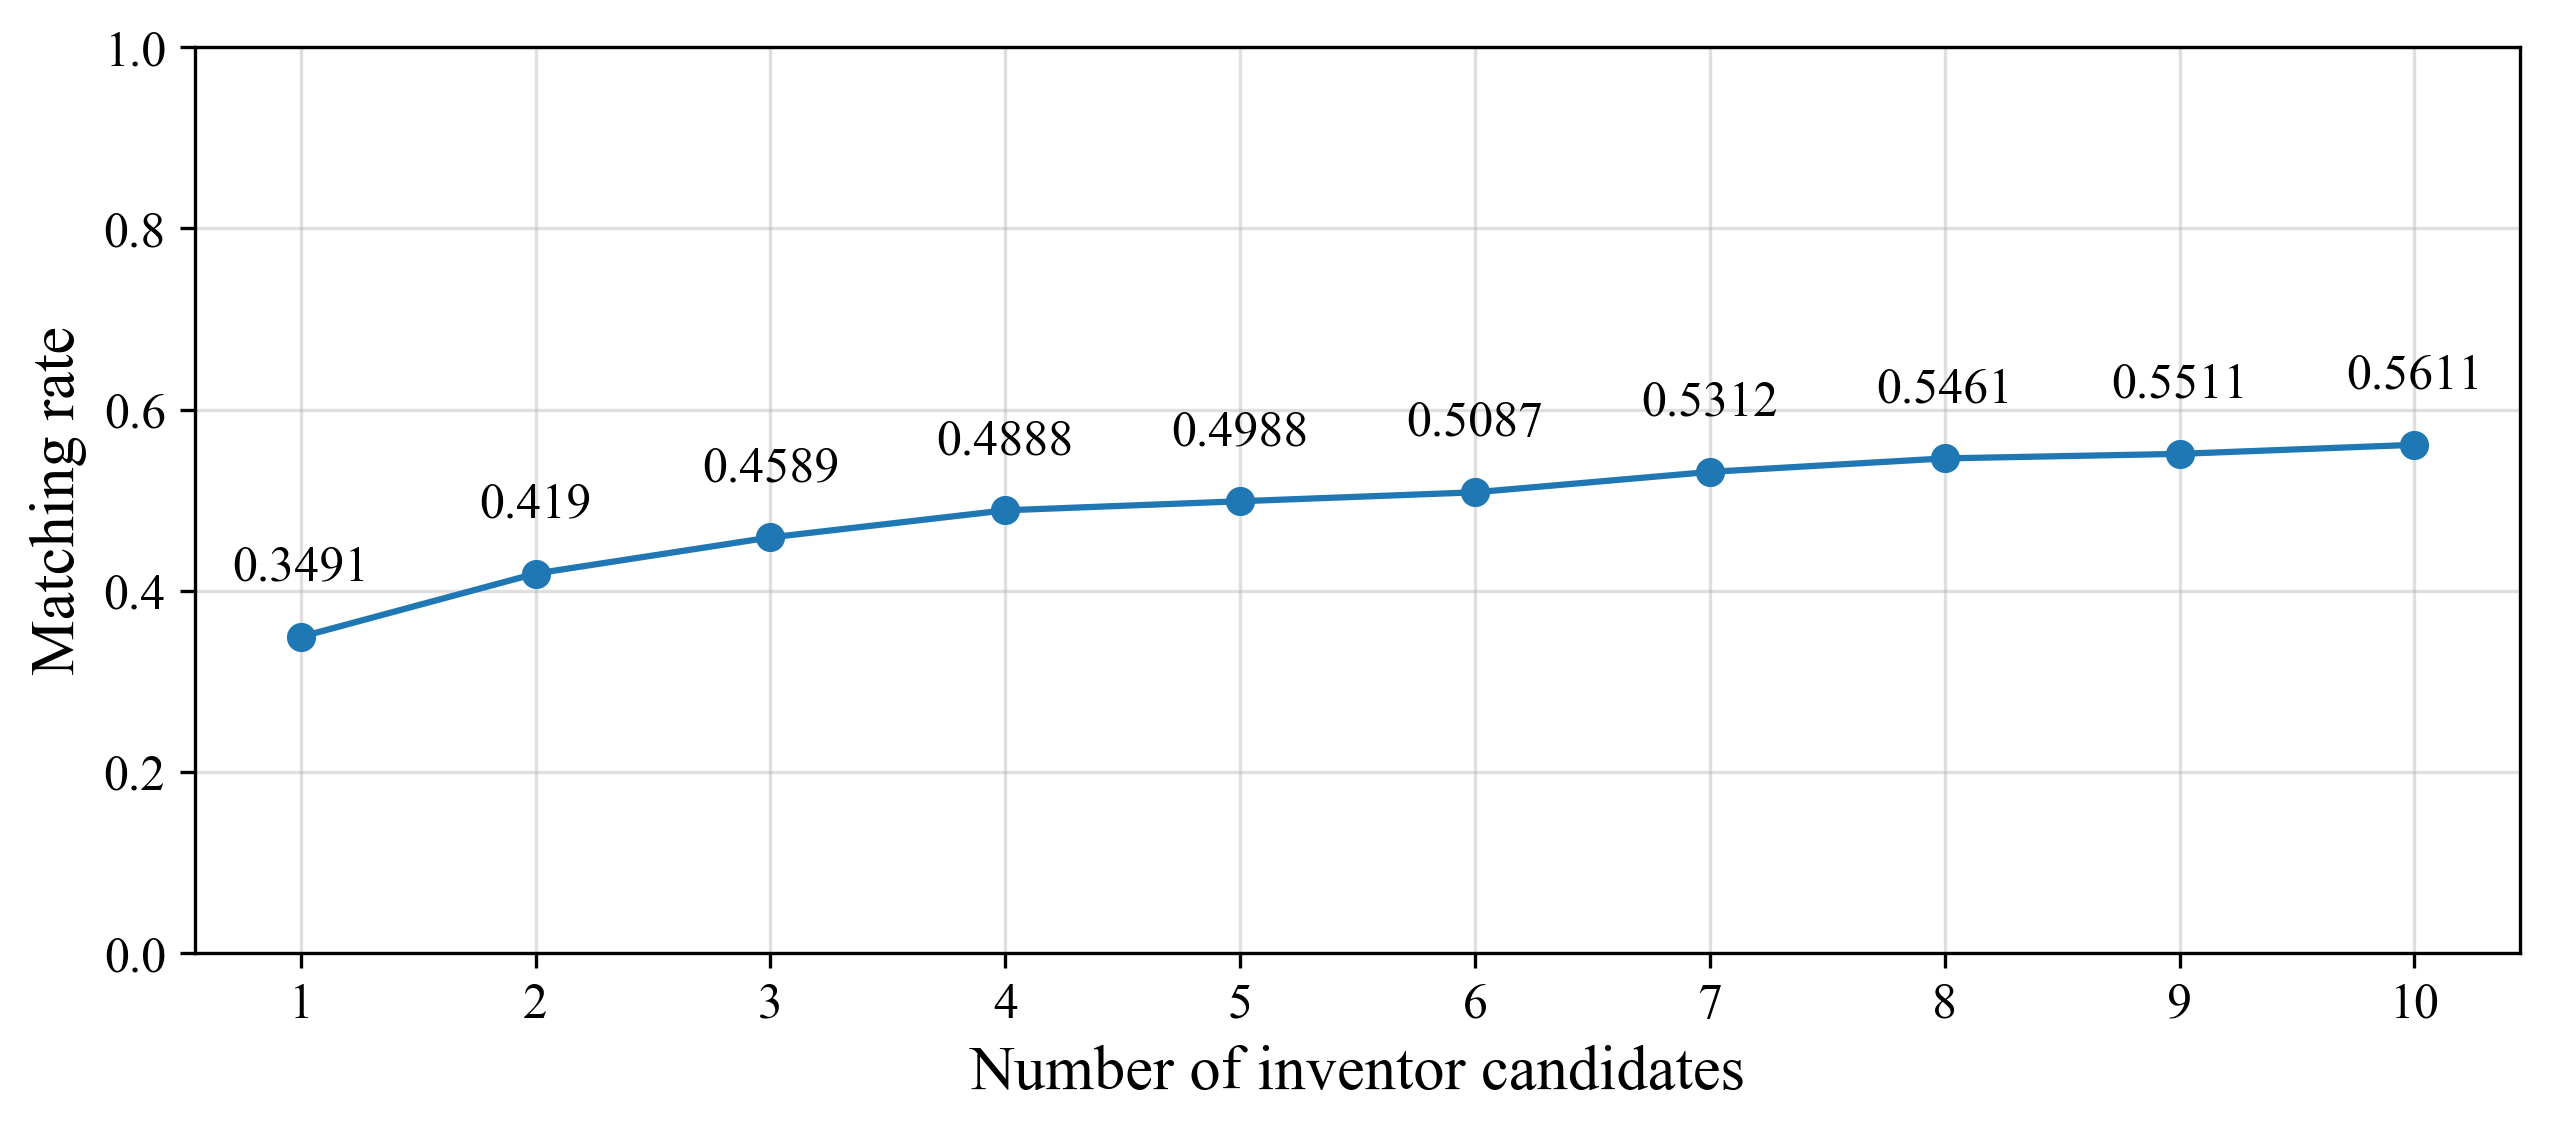

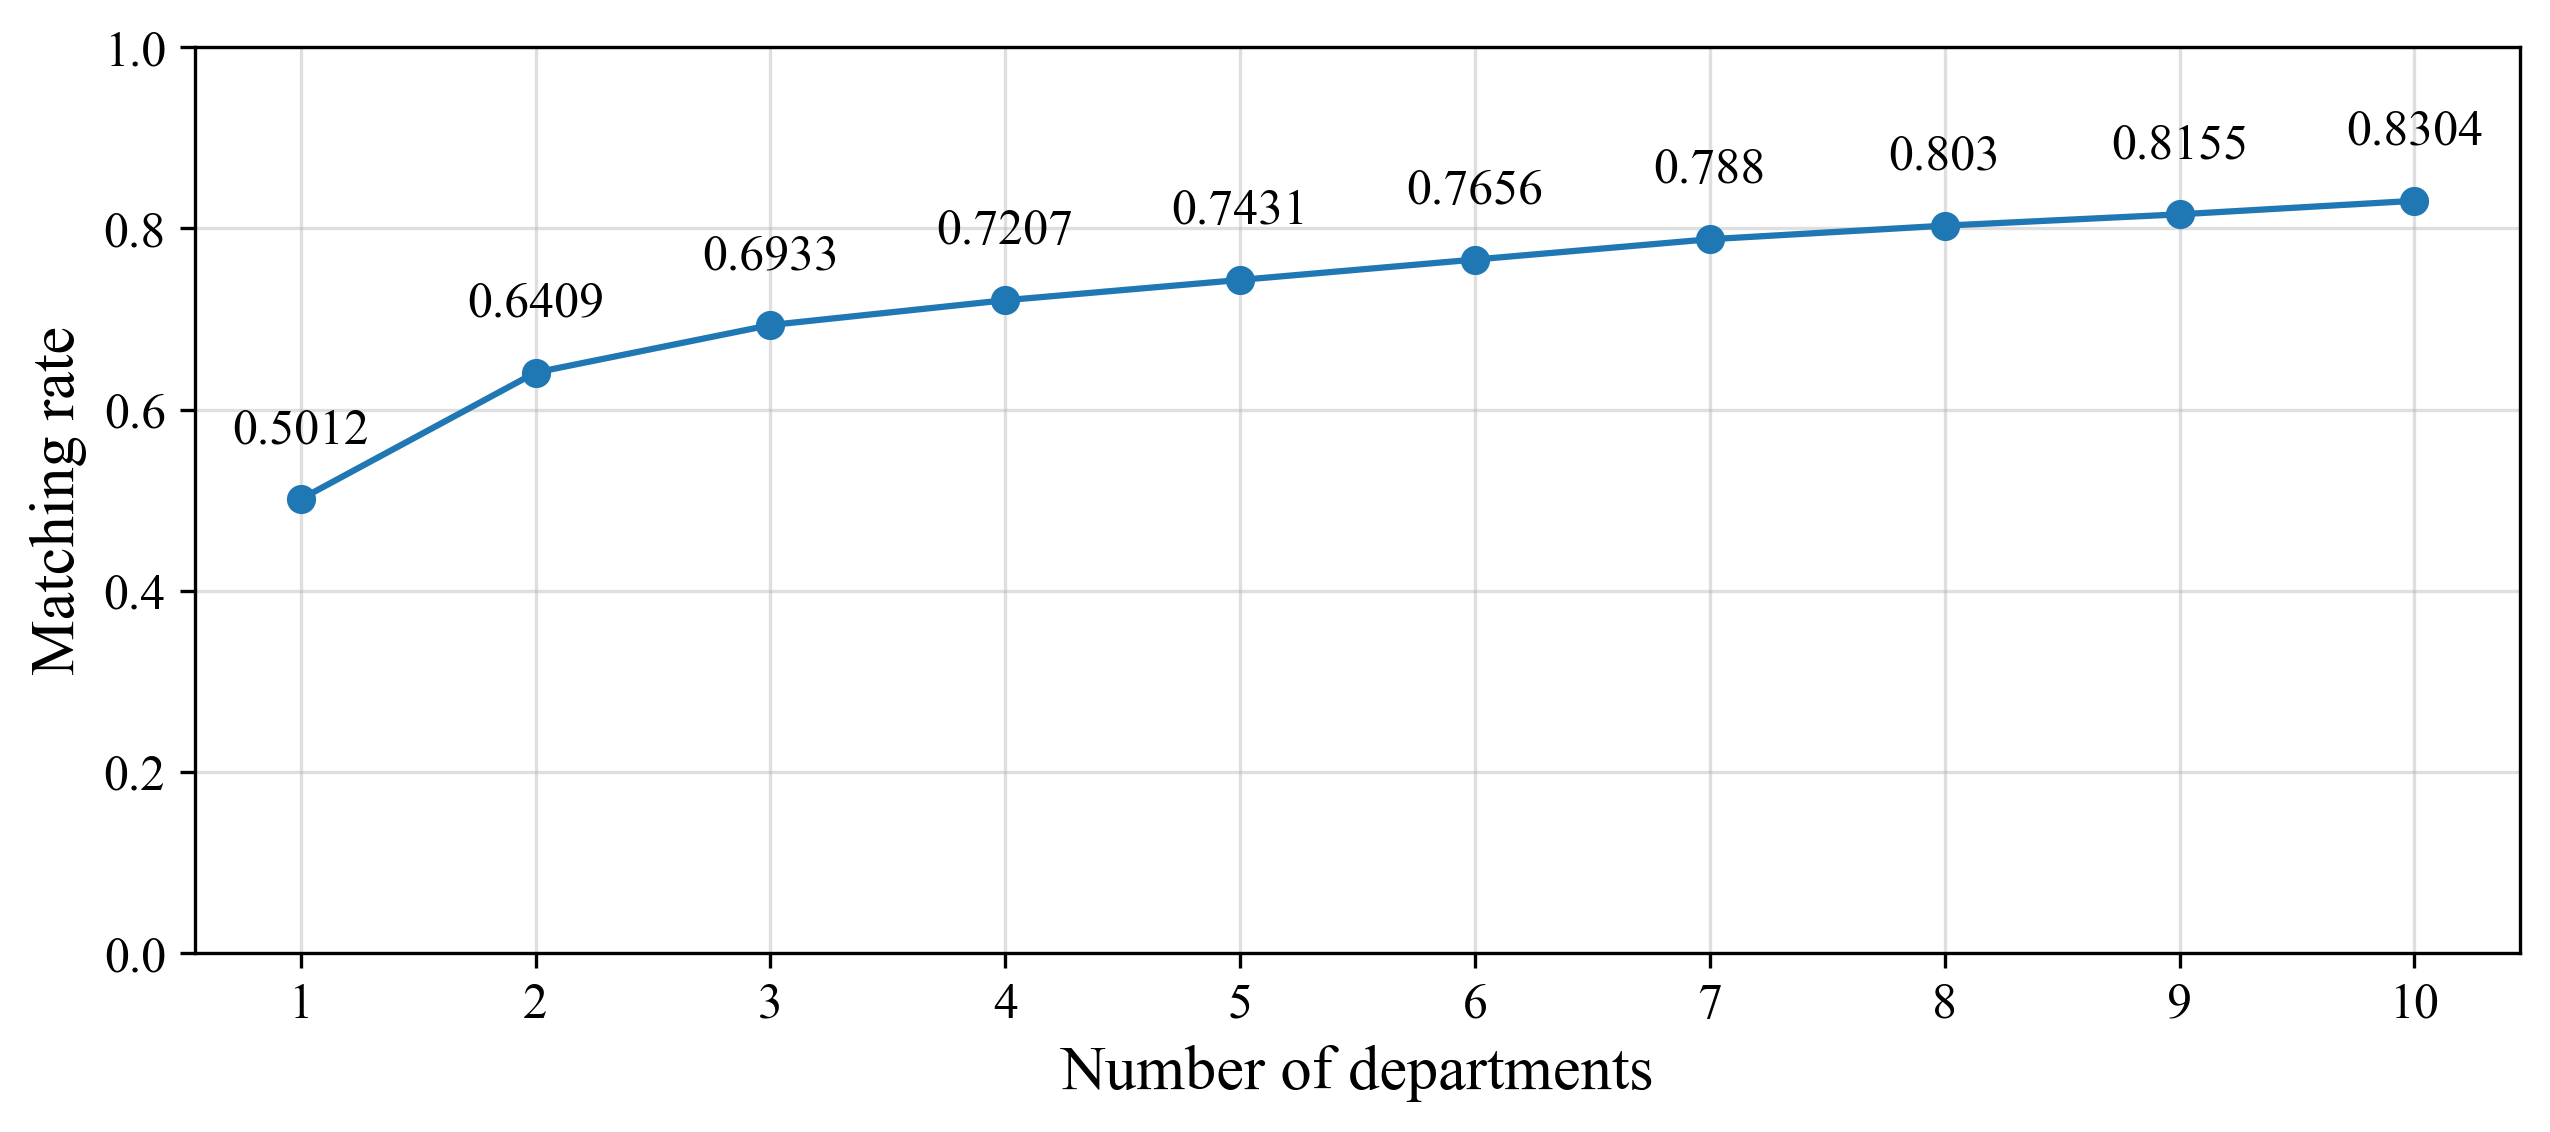

In [472]:
# %matplotlib inline
plt.rcParams['font.family'] = 'Times New Roman'

fig, ax = plt.subplots(figsize=(10,4), dpi=300)
ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['inventor']):
    ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
ax.set_ylim([0,1])
ax.set_xlabel('Number of inventor candidates', fontsize=15)
ax.set_ylabel('Matching rate', fontsize=15)
ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Inventor.jpg")

fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
for i, v in enumerate(matching_rate['department']):
    ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
ax2.set_ylim([0,1])
ax2.set_xlabel('Number of departments', fontsize=15)
ax2.set_ylabel('Matching rate', fontsize=15)
ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
ax2.grid(alpha=0.4)
# plt.show()
plt.savefig("../results/Matching_rate_Department.jpg")

In [476]:
def get_result(method='avg'):
    print(f"For METHOD {method}")
    
    vec_tech = calc_vec(ft_model, list_tech, method=method, list_total=list_total)
    vec_inv = calc_vec(ft_model, list_inv, method=method, list_total=list_total)
    top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=10)

    idx = 16
    matchmaking_example = pd.concat([pd.Series(['TITLE_tech', 'NAME_tech', 'NAME_IND_tech', 'DEPART_tech', 'DEPART_IND_tech', 'Similarity']), pd.Series([title_tech[index_tech[idx]], technologies.loc[index_tech[idx]]['name'], "NAME_"+str(technologies.loc[index_tech[idx]]['name_idx']), technologies.loc[index_tech[idx]]['department'], "DEPART_"+str(technologies.loc[index_tech[idx]]['depart_idx']), 1.0]), pd.Series(['TITLE_inv', 'NAME_inv', 'NAME_IND_inv', 'DEPART_inv', 'DEPART_IND_inv', 'Similarity'])], axis=1)
    for i in range(len(top_candidates[index_tech[idx]]['title'])):
        matchmaking_example = pd.concat([matchmaking_example, pd.Series([top_candidates[index_tech[idx]]['title'].iloc[i], top_candidates[index_tech[idx]]['inventor'].iloc[i], "NAME_"+str(top_candidates[index_tech[idx]]['inventor_idx'].iloc[i]), top_candidates[index_tech[idx]]['department'].iloc[i], "DEPART_"+str(top_candidates[index_tech[idx]]['department_idx'].iloc[i]), str(np.round(1-top_candidates[index_tech[idx]]['distance'].iloc[i], 4))])], axis=1)
    matchmaking_example = matchmaking_example.T

    display(matchmaking_example)
    
    # Matching ratio
    matching_rate = {'inventor': [], 'department': []}
    for k in range(1,11):
        print("For top",k)
        top_candidates = calc_rank(vec_tech, vec_inv, title_tech, title_inv, topk=k)
        eval_matched = {}
        cnt_matched = {}
        cnt_matched['inventor'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
        cnt_matched['department'] = pd.Series(np.zeros_like(vec_tech.index), index=vec_tech.index)
        for id_target in tqdm(vec_tech.index):
            if outcomes.loc[id_target]['성명'] in list(top_candidates[id_target]['inventor']):
                cnt_matched['inventor'].loc[id_target] += 1
            if outcomes.loc[id_target]['소속명'] in list(top_candidates[id_target]['department']):
                cnt_matched['department'].loc[id_target] += 1
        eval_matched['inventor'] = np.round(len(cnt_matched['inventor'][cnt_matched['inventor']==1]) / len(cnt_matched['inventor']), 4)
        eval_matched['department'] = np.round(len(cnt_matched['department'][cnt_matched['department']==1]) / len(cnt_matched['department']), 4)
        print("Hit ratio (inventor):", eval_matched['inventor'])
        print("Hit ratio (department):", eval_matched['department'])
        print("\n")
        matching_rate['inventor'].append(eval_matched['inventor'])
        matching_rate['department'].append(eval_matched['department'])
        
    # %matplotlib inline
    plt.rcParams['font.family'] = 'Times New Roman'

    fig, ax = plt.subplots(figsize=(10,4), dpi=300)
    ax.plot(np.arange(1,len(matching_rate['inventor'])+1), matching_rate['inventor'], linestyle='solid', marker='o')
    for i, v in enumerate(matching_rate['inventor']):
        ax.text(i+1, matching_rate['inventor'][i]+0.05, matching_rate['inventor'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax.set_xticks(np.arange(1,len(matching_rate['inventor'])+1))
    ax.set_ylim([0,1])
    ax.set_xlabel('Number of inventor candidates', fontsize=15)
    ax.set_ylabel('Matching rate', fontsize=15)
    ax.set_xticklabels(np.arange(1,len(matching_rate['inventor'])+1), fontsize=12)
    ax.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
    ax.grid(alpha=0.4)
    plt.show()
#     plt.savefig("../results/Matching_rate_Inventor.jpg")

    fig, ax2 = plt.subplots(figsize=(10,4), dpi=300)
    ax2.plot(np.arange(1,len(matching_rate['department'])+1), matching_rate['department'], linestyle='solid', marker='o')
    for i, v in enumerate(matching_rate['department']):
        ax2.text(i+1, matching_rate['department'][i]+0.05, matching_rate['department'][i], color='black', horizontalalignment='center', verticalalignment='bottom', fontsize=12)
    ax2.set_xticks(np.arange(1,len(matching_rate['department'])+1))
    ax2.set_ylim([0,1])
    ax2.set_xlabel('Number of departments', fontsize=15)
    ax2.set_ylabel('Matching rate', fontsize=15)
    ax2.set_xticklabels(np.arange(1,len(matching_rate['department'])+1), fontsize=12)
    ax2.set_yticklabels(np.round(ax.get_yticks(),1).astype('str'), fontsize=12)
    ax2.grid(alpha=0.4)
    plt.show()
#     plt.savefig("../results/Matching_rate_Department.jpg")
    print("-"*50)

  8%|▊         | 1336/16517 [00:00<00:01, 13354.95it/s]

For METHOD avg


100%|██████████| 401/401 [00:04<00:00, 96.41it/s]


,0,1,2,3,4,5
0,TITLE_tech,NAME_tech,NAME_IND_tech,DEPART_tech,DEPART_IND_tech,Similarity
1,Prior to the Color Doppler-based technical know-how available on wireless ultrasonic medical dev...,송태경,NAME_279,전자공학전공,DEPART_53,1
2,TITLE_inv,NAME_inv,NAME_IND_inv,DEPART_inv,DEPART_IND_inv,Similarity
0,Development of high-speed/high-definition medical imaging technology,송태경,NAME_279,전자공학전공,DEPART_53,0.8623
0,Development of Bluetooth chopping analysis tool based on incoming sound and aptX HD oh,소재우,NAME_266,전자공학전공,DEPART_53,0.8454
0,Bluetooth to help infants sleep properly (customized-implementary),홍철기,NAME_620,경영전문대학원,DEPART_2,0.8408
0,Design and build sensing data as a secure and reliable service,박석,NAME_212,컴퓨터공학전공,DEPART_60,0.8346
0,Internal and external instruments for human balance calibration based on respiratory mechanics u...,최범규,NAME_569,기계공학전공,DEPART_14,0.8341
0,Image processing methods and devices that perform integrated multi-scale retinex in CIELAB color...,박형민,NAME_237,전자공학전공,DEPART_53,0.833
0,Measure and analyze digital media usage and digital literacy for people with disabilities:,조재희,NAME_550,미디어&엔터테인먼트전공,DEPART_22,0.8302


For top 1


100%|██████████| 401/401 [00:00<00:00, 1432.92it/s]


Hit ratio (inventor): 0.3616
Hit ratio (department): 0.5561


For top 2


100%|██████████| 401/401 [00:00<00:00, 1368.77it/s]


Hit ratio (inventor): 0.414
Hit ratio (department): 0.6484


For top 3


100%|██████████| 401/401 [00:00<00:00, 1008.95it/s]


Hit ratio (inventor): 0.4613
Hit ratio (department): 0.7057


For top 4


100%|██████████| 401/401 [00:00<00:00, 1285.08it/s]


Hit ratio (inventor): 0.4888
Hit ratio (department): 0.7357


For top 5


100%|██████████| 401/401 [00:00<00:00, 1278.47it/s]


Hit ratio (inventor): 0.5062
Hit ratio (department): 0.7606


For top 6


100%|██████████| 401/401 [00:00<00:00, 1248.60it/s]


Hit ratio (inventor): 0.5262
Hit ratio (department): 0.7855


For top 7


100%|██████████| 401/401 [00:00<00:00, 1233.18it/s]


Hit ratio (inventor): 0.5387
Hit ratio (department): 0.798


For top 8


100%|██████████| 401/401 [00:00<00:00, 1232.69it/s]


Hit ratio (inventor): 0.5436
Hit ratio (department): 0.813


For top 9


100%|██████████| 401/401 [00:00<00:00, 1229.93it/s]


Hit ratio (inventor): 0.5561
Hit ratio (department): 0.8229


For top 10


100%|██████████| 401/401 [00:00<00:00, 1227.52it/s]


Hit ratio (inventor): 0.5586
Hit ratio (department): 0.8279




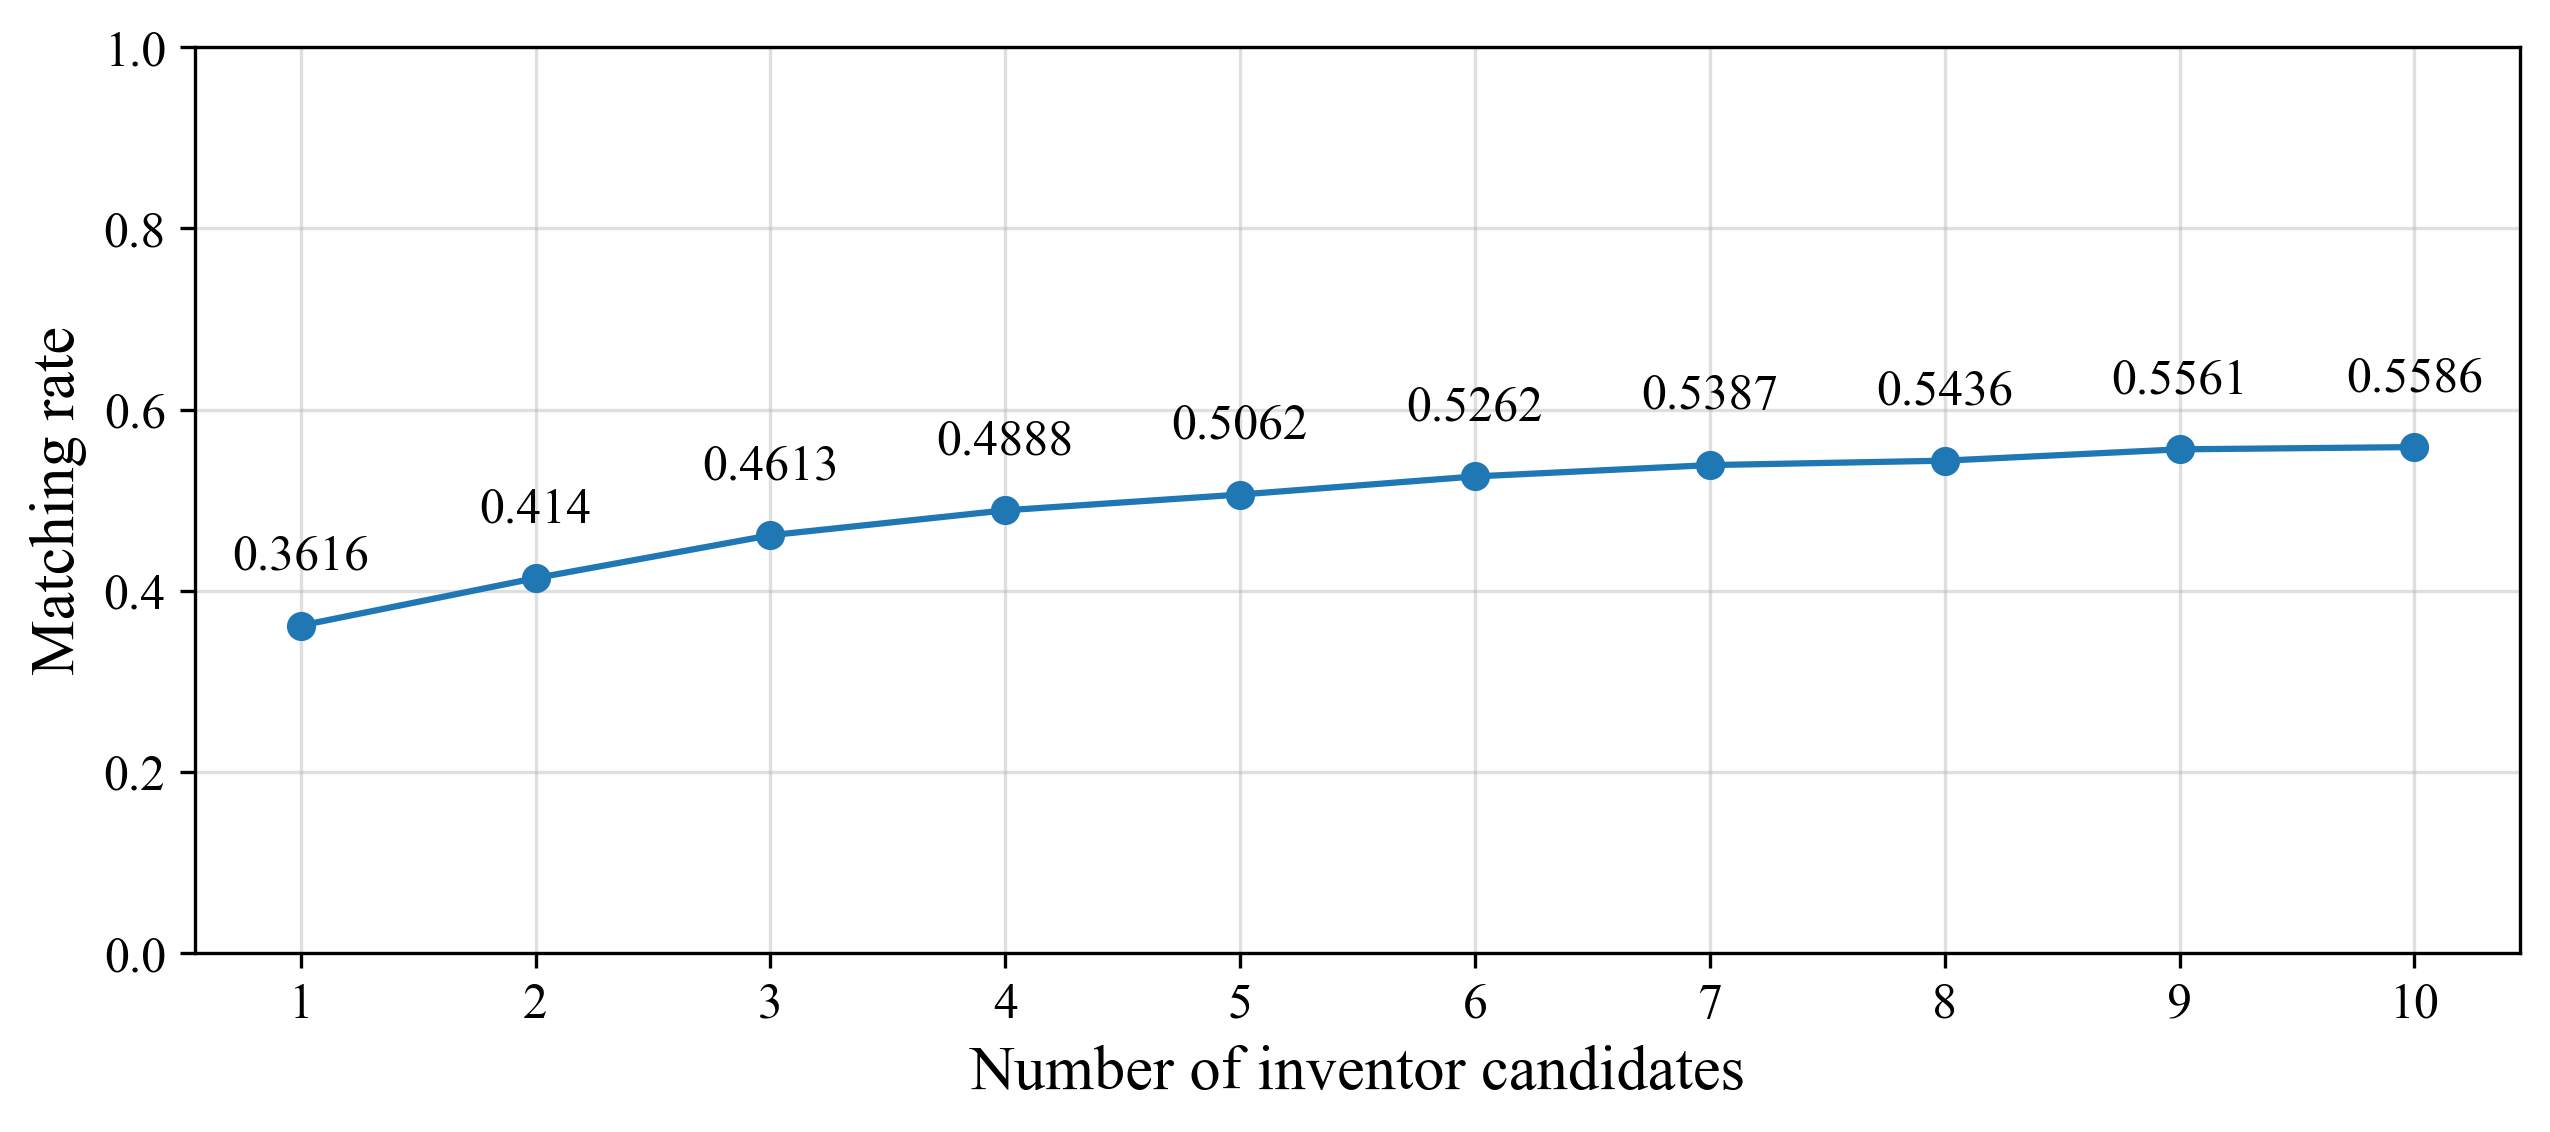

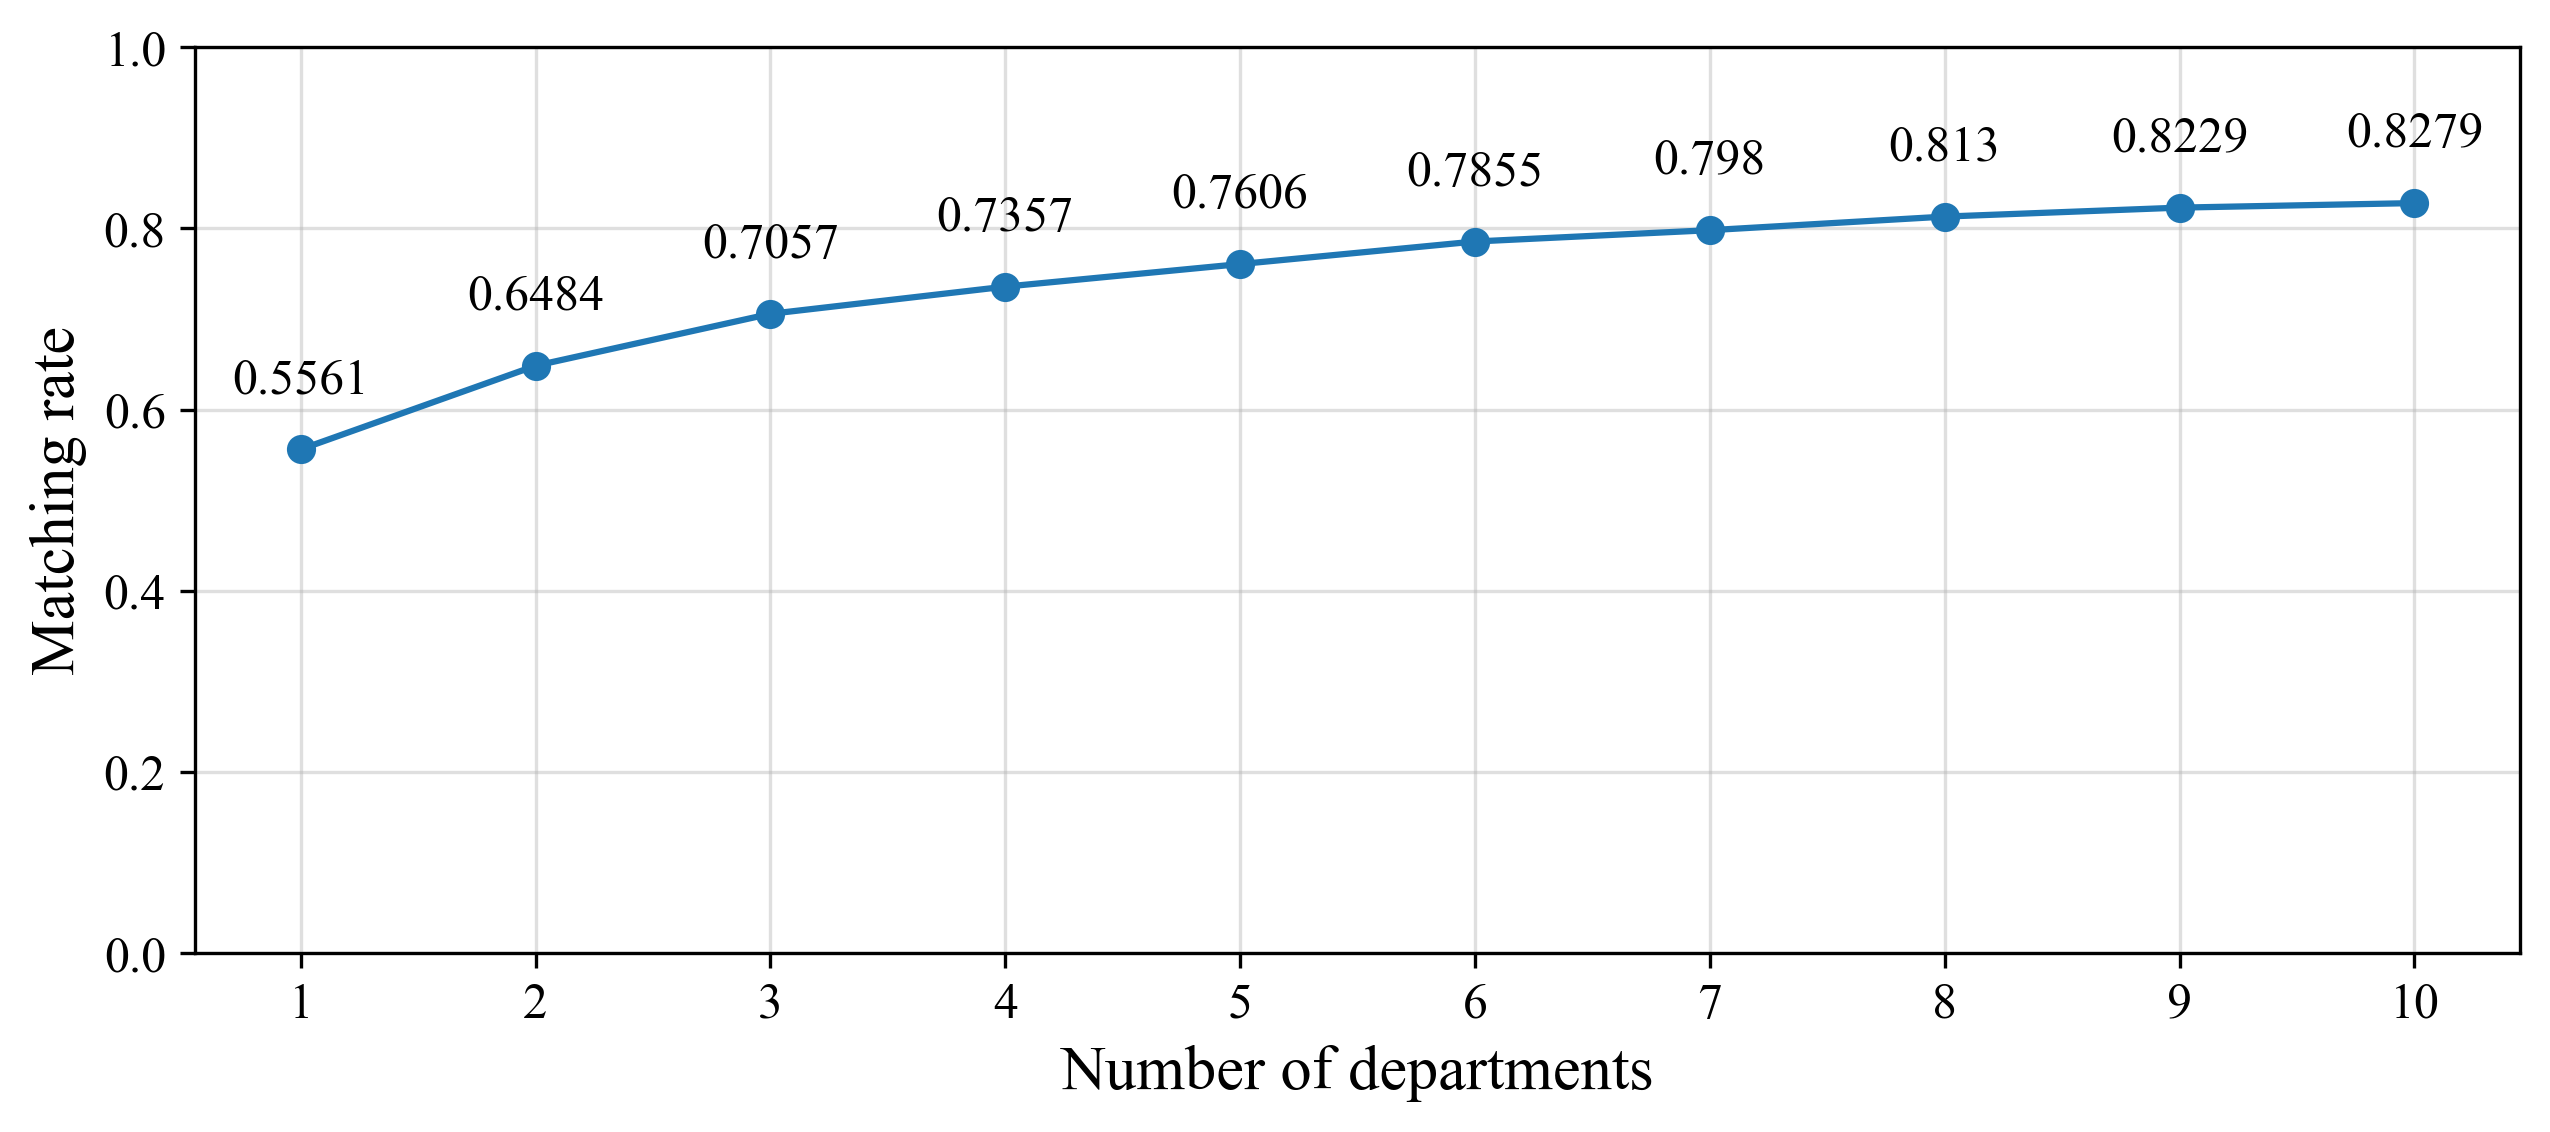

 10%|█         | 1679/16517 [00:00<00:00, 16783.17it/s]

--------------------------------------------------
For METHOD sum


100%|██████████| 401/401 [00:03<00:00, 114.11it/s]


,0,1,2,3,4,5
0,TITLE_tech,NAME_tech,NAME_IND_tech,DEPART_tech,DEPART_IND_tech,Similarity
1,Prior to the Color Doppler-based technical know-how available on wireless ultrasonic medical dev...,송태경,NAME_279,전자공학전공,DEPART_53,1
2,TITLE_inv,NAME_inv,NAME_IND_inv,DEPART_inv,DEPART_IND_inv,Similarity
0,Development of high-speed/high-definition medical imaging technology,송태경,NAME_279,전자공학전공,DEPART_53,0.8623
0,Development of Bluetooth chopping analysis tool based on incoming sound and aptX HD oh,소재우,NAME_266,전자공학전공,DEPART_53,0.8454
0,Bluetooth to help infants sleep properly (customized-implementary),홍철기,NAME_620,경영전문대학원,DEPART_2,0.8408
0,Design and build sensing data as a secure and reliable service,박석,NAME_212,컴퓨터공학전공,DEPART_60,0.8346
0,Internal and external instruments for human balance calibration based on respiratory mechanics u...,최범규,NAME_569,기계공학전공,DEPART_14,0.8341
0,Image processing methods and devices that perform integrated multi-scale retinex in CIELAB color...,박형민,NAME_237,전자공학전공,DEPART_53,0.833
0,Measure and analyze digital media usage and digital literacy for people with disabilities:,조재희,NAME_550,미디어&엔터테인먼트전공,DEPART_22,0.8302


For top 1


100%|██████████| 401/401 [00:00<00:00, 1406.39it/s]


Hit ratio (inventor): 0.3616
Hit ratio (department): 0.5561


For top 2


100%|██████████| 401/401 [00:00<00:00, 1329.74it/s]


Hit ratio (inventor): 0.414
Hit ratio (department): 0.6484


For top 3


100%|██████████| 401/401 [00:00<00:00, 1292.18it/s]


Hit ratio (inventor): 0.4613
Hit ratio (department): 0.7057


For top 4


100%|██████████| 401/401 [00:00<00:00, 1285.34it/s]


Hit ratio (inventor): 0.4888
Hit ratio (department): 0.7357


For top 5


100%|██████████| 401/401 [00:00<00:00, 1242.85it/s]


Hit ratio (inventor): 0.5062
Hit ratio (department): 0.7606


For top 6


100%|██████████| 401/401 [00:00<00:00, 1249.21it/s]


Hit ratio (inventor): 0.5262
Hit ratio (department): 0.7855


For top 7


100%|██████████| 401/401 [00:00<00:00, 1235.44it/s]


Hit ratio (inventor): 0.5387
Hit ratio (department): 0.798


For top 8


100%|██████████| 401/401 [00:00<00:00, 1231.75it/s]


Hit ratio (inventor): 0.5436
Hit ratio (department): 0.813


For top 9


100%|██████████| 401/401 [00:00<00:00, 1223.58it/s]


Hit ratio (inventor): 0.5561
Hit ratio (department): 0.8229


For top 10


100%|██████████| 401/401 [00:00<00:00, 1226.20it/s]


Hit ratio (inventor): 0.5586
Hit ratio (department): 0.8279




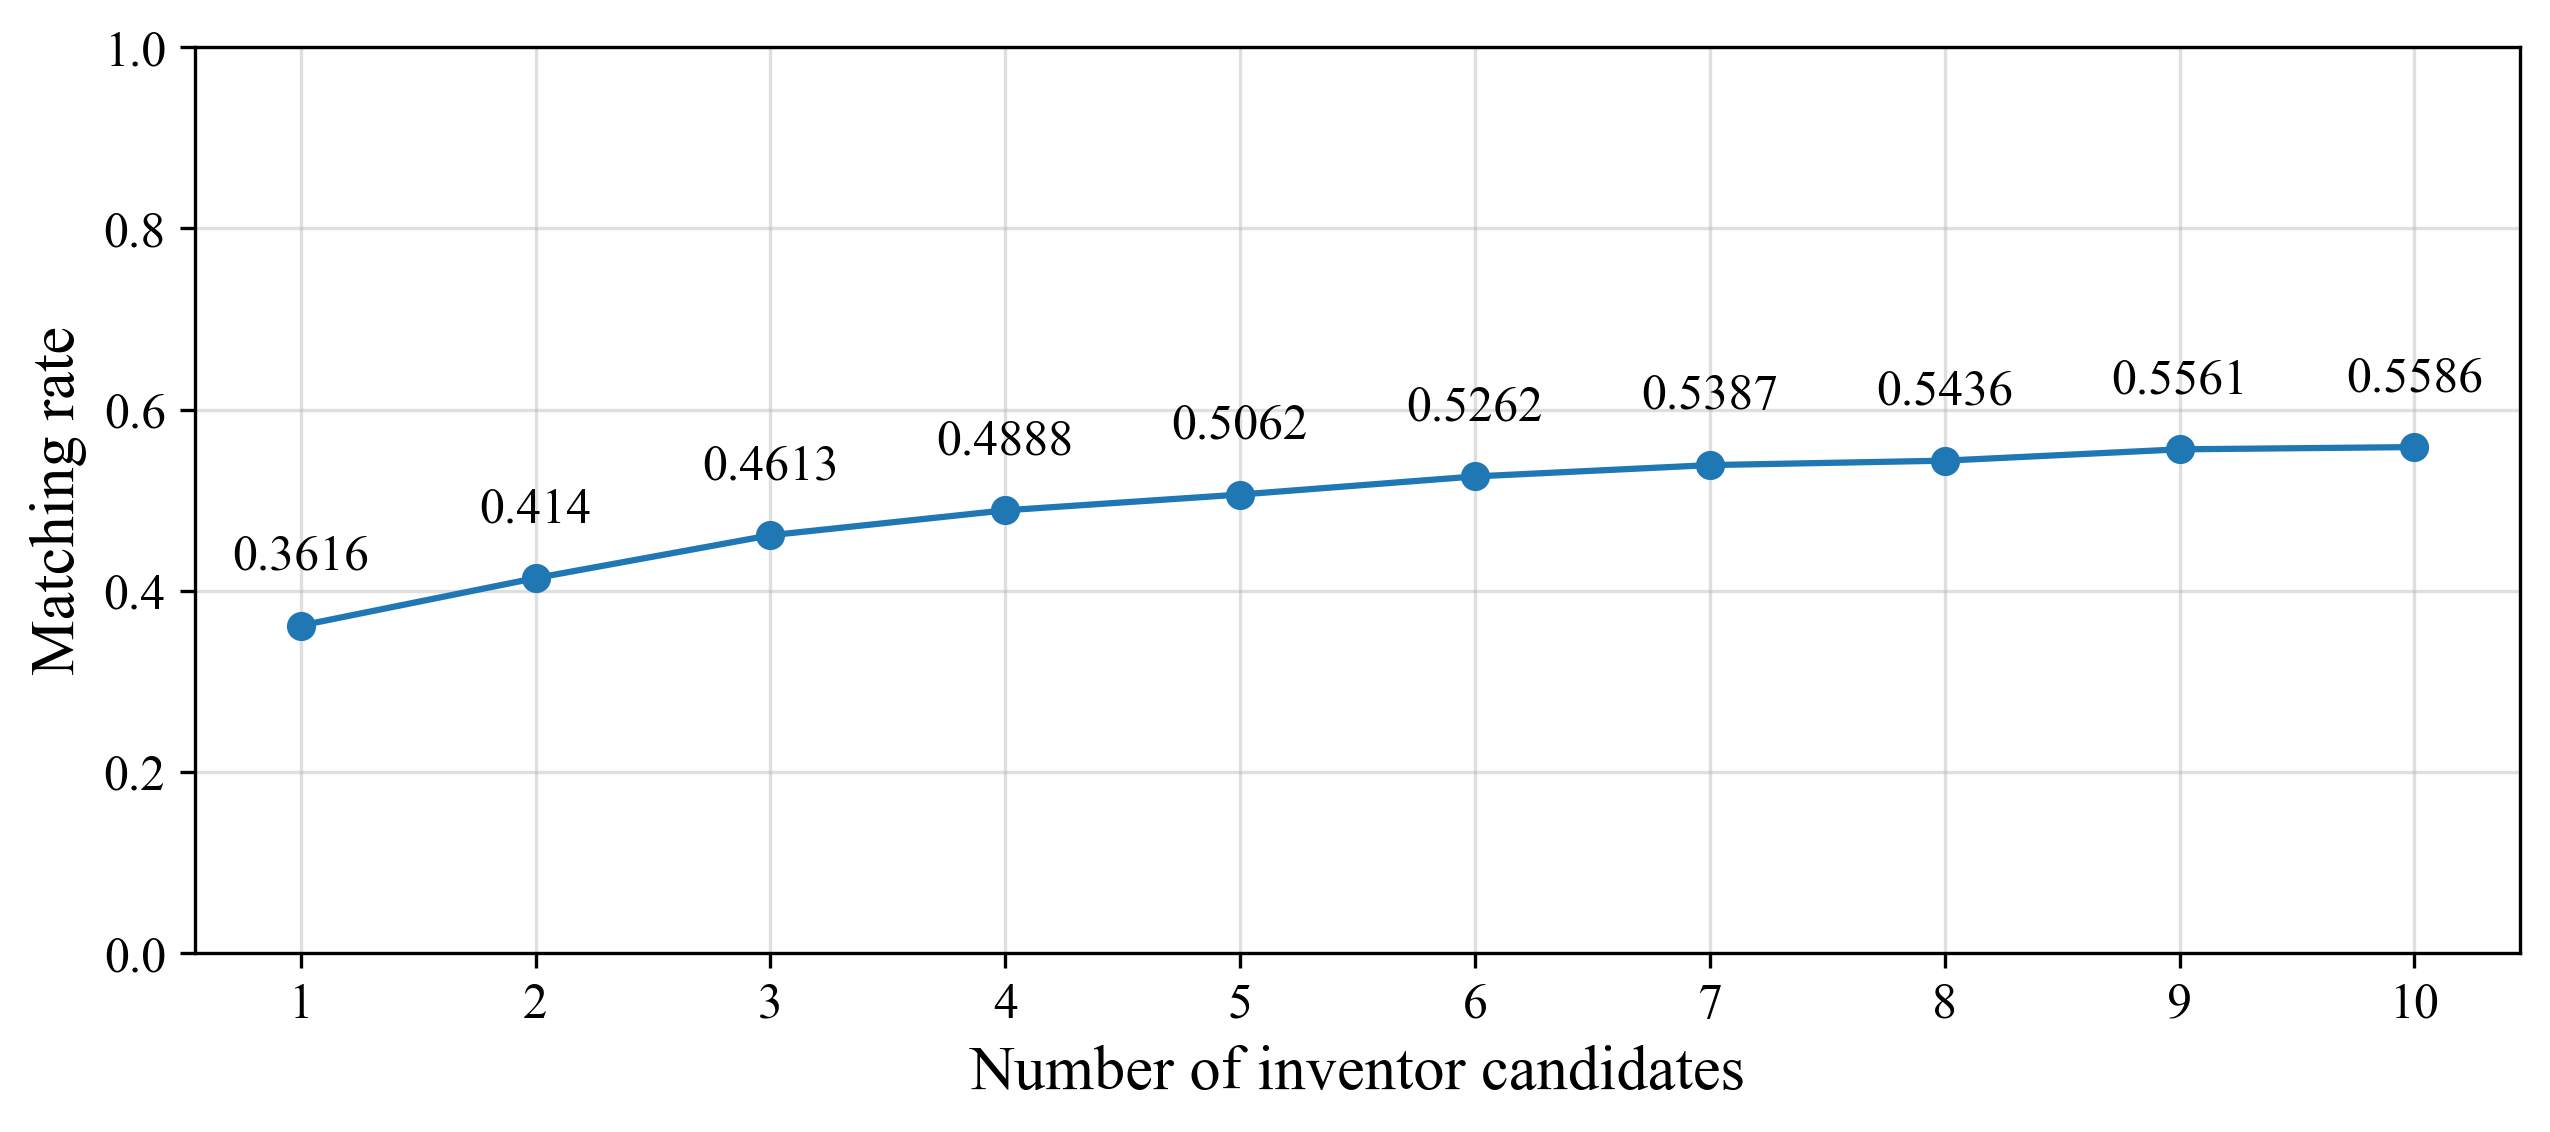

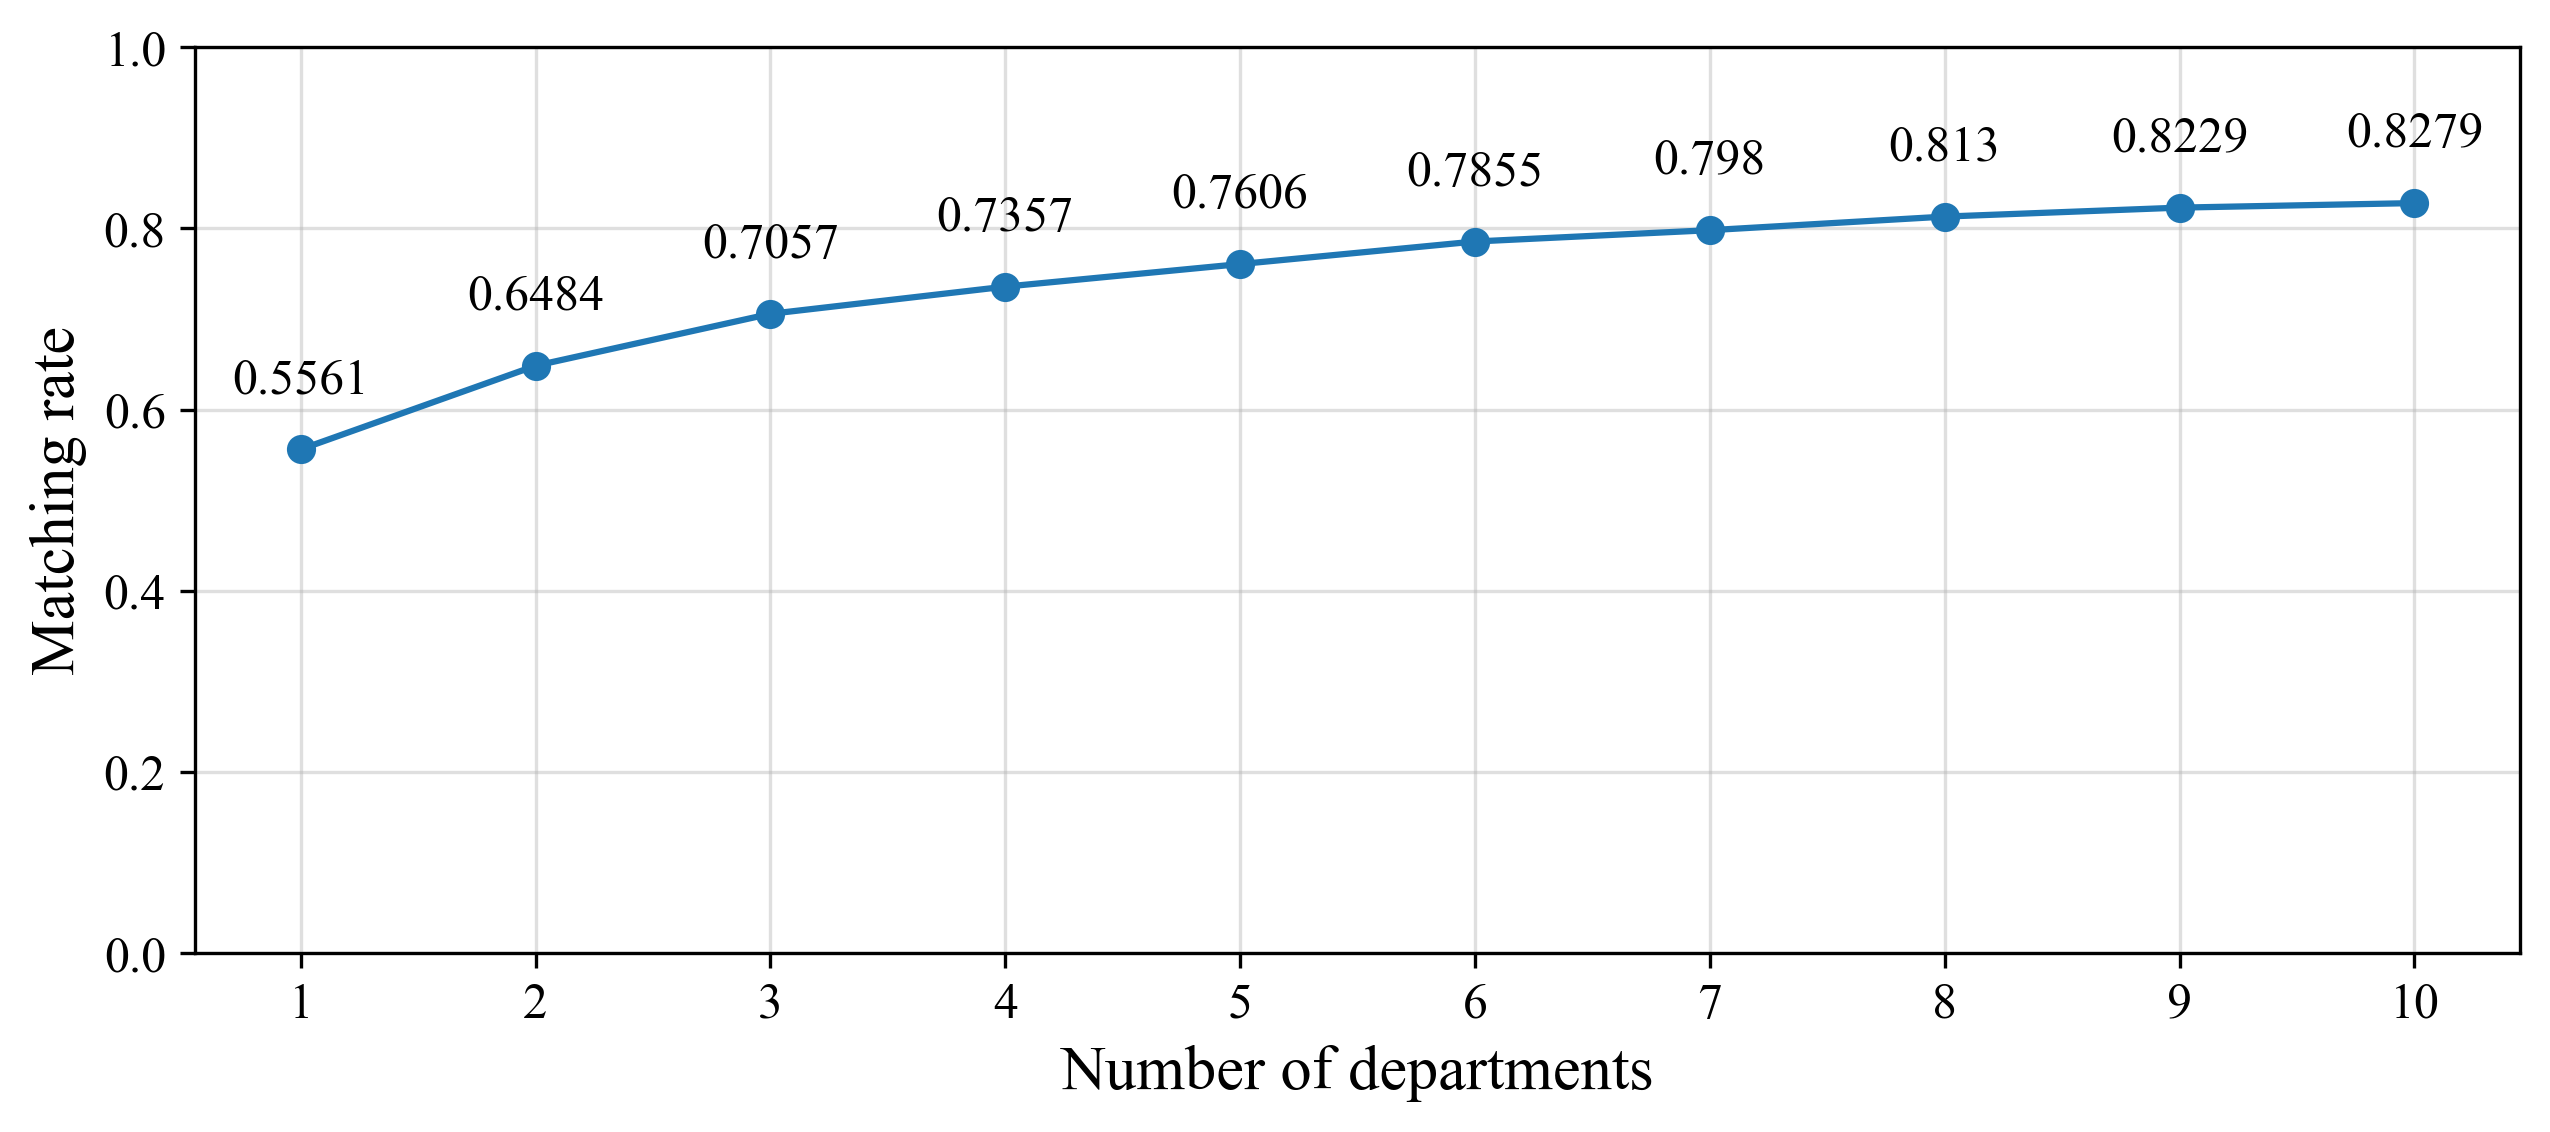

100%|██████████| 401/401 [00:00<00:00, 11587.35it/s]

--------------------------------------------------
For METHOD sif



100%|██████████| 401/401 [00:03<00:00, 116.91it/s]


,0,1,2,3,4,5
0,TITLE_tech,NAME_tech,NAME_IND_tech,DEPART_tech,DEPART_IND_tech,Similarity
1,Prior to the Color Doppler-based technical know-how available on wireless ultrasonic medical dev...,송태경,NAME_279,전자공학전공,DEPART_53,1
2,TITLE_inv,NAME_inv,NAME_IND_inv,DEPART_inv,DEPART_IND_inv,Similarity
0,Image processing methods and devices that perform integrated multi-scale retinex in CIELAB color...,박형민,NAME_237,전자공학전공,DEPART_53,0.4674
0,To generate spectral Doppler images and their ultrasonic Doppler imaging devices,유양모,NAME_337,전자공학전공,DEPART_53,0.4585
0,"Inside the spiral: Hostile media, minority perception, and willingness to speak out on a weblog",이수영,NAME_390,영상대학원,DEPART_49,0.453
0,Method of signal redundancy correction in medical imaging devices using multiple threshold volta...,김규범,NAME_69,전자공학전공,DEPART_53,0.4524
0,A study on images that can give intensive perception in photo archive exhibition,최용순,NAME_575,영상대학원,DEPART_49,0.4483
0,Spectrum detection methods and devices using mutual information volumes in cognitive wireless ne...,소재우,NAME_266,전자공학전공,DEPART_53,0.4464
0,How to measure and transmit downward link signals and devices for this.,성원진,NAME_264,전자공학전공,DEPART_53,0.4425


For top 1


100%|██████████| 401/401 [00:00<00:00, 1421.87it/s]


Hit ratio (inventor): 0.3441
Hit ratio (department): 0.4963


For top 2


100%|██████████| 401/401 [00:00<00:00, 1338.90it/s]


Hit ratio (inventor): 0.3915
Hit ratio (department): 0.6334


For top 3


100%|██████████| 401/401 [00:00<00:00, 1284.75it/s]


Hit ratio (inventor): 0.4389
Hit ratio (department): 0.6858


For top 4


100%|██████████| 401/401 [00:00<00:00, 1252.91it/s]


Hit ratio (inventor): 0.4713
Hit ratio (department): 0.7232


For top 5


100%|██████████| 401/401 [00:00<00:00, 1271.12it/s]


Hit ratio (inventor): 0.4863
Hit ratio (department): 0.7506


For top 6


100%|██████████| 401/401 [00:00<00:00, 1214.78it/s]


Hit ratio (inventor): 0.5062
Hit ratio (department): 0.7731


For top 7


100%|██████████| 401/401 [00:00<00:00, 1234.18it/s]


Hit ratio (inventor): 0.5212
Hit ratio (department): 0.793


For top 8


100%|██████████| 401/401 [00:00<00:00, 1242.28it/s]


Hit ratio (inventor): 0.5312
Hit ratio (department): 0.808


For top 9


100%|██████████| 401/401 [00:00<00:00, 1235.96it/s]


Hit ratio (inventor): 0.5461
Hit ratio (department): 0.8229


For top 10


100%|██████████| 401/401 [00:00<00:00, 1238.81it/s]


Hit ratio (inventor): 0.5536
Hit ratio (department): 0.8329




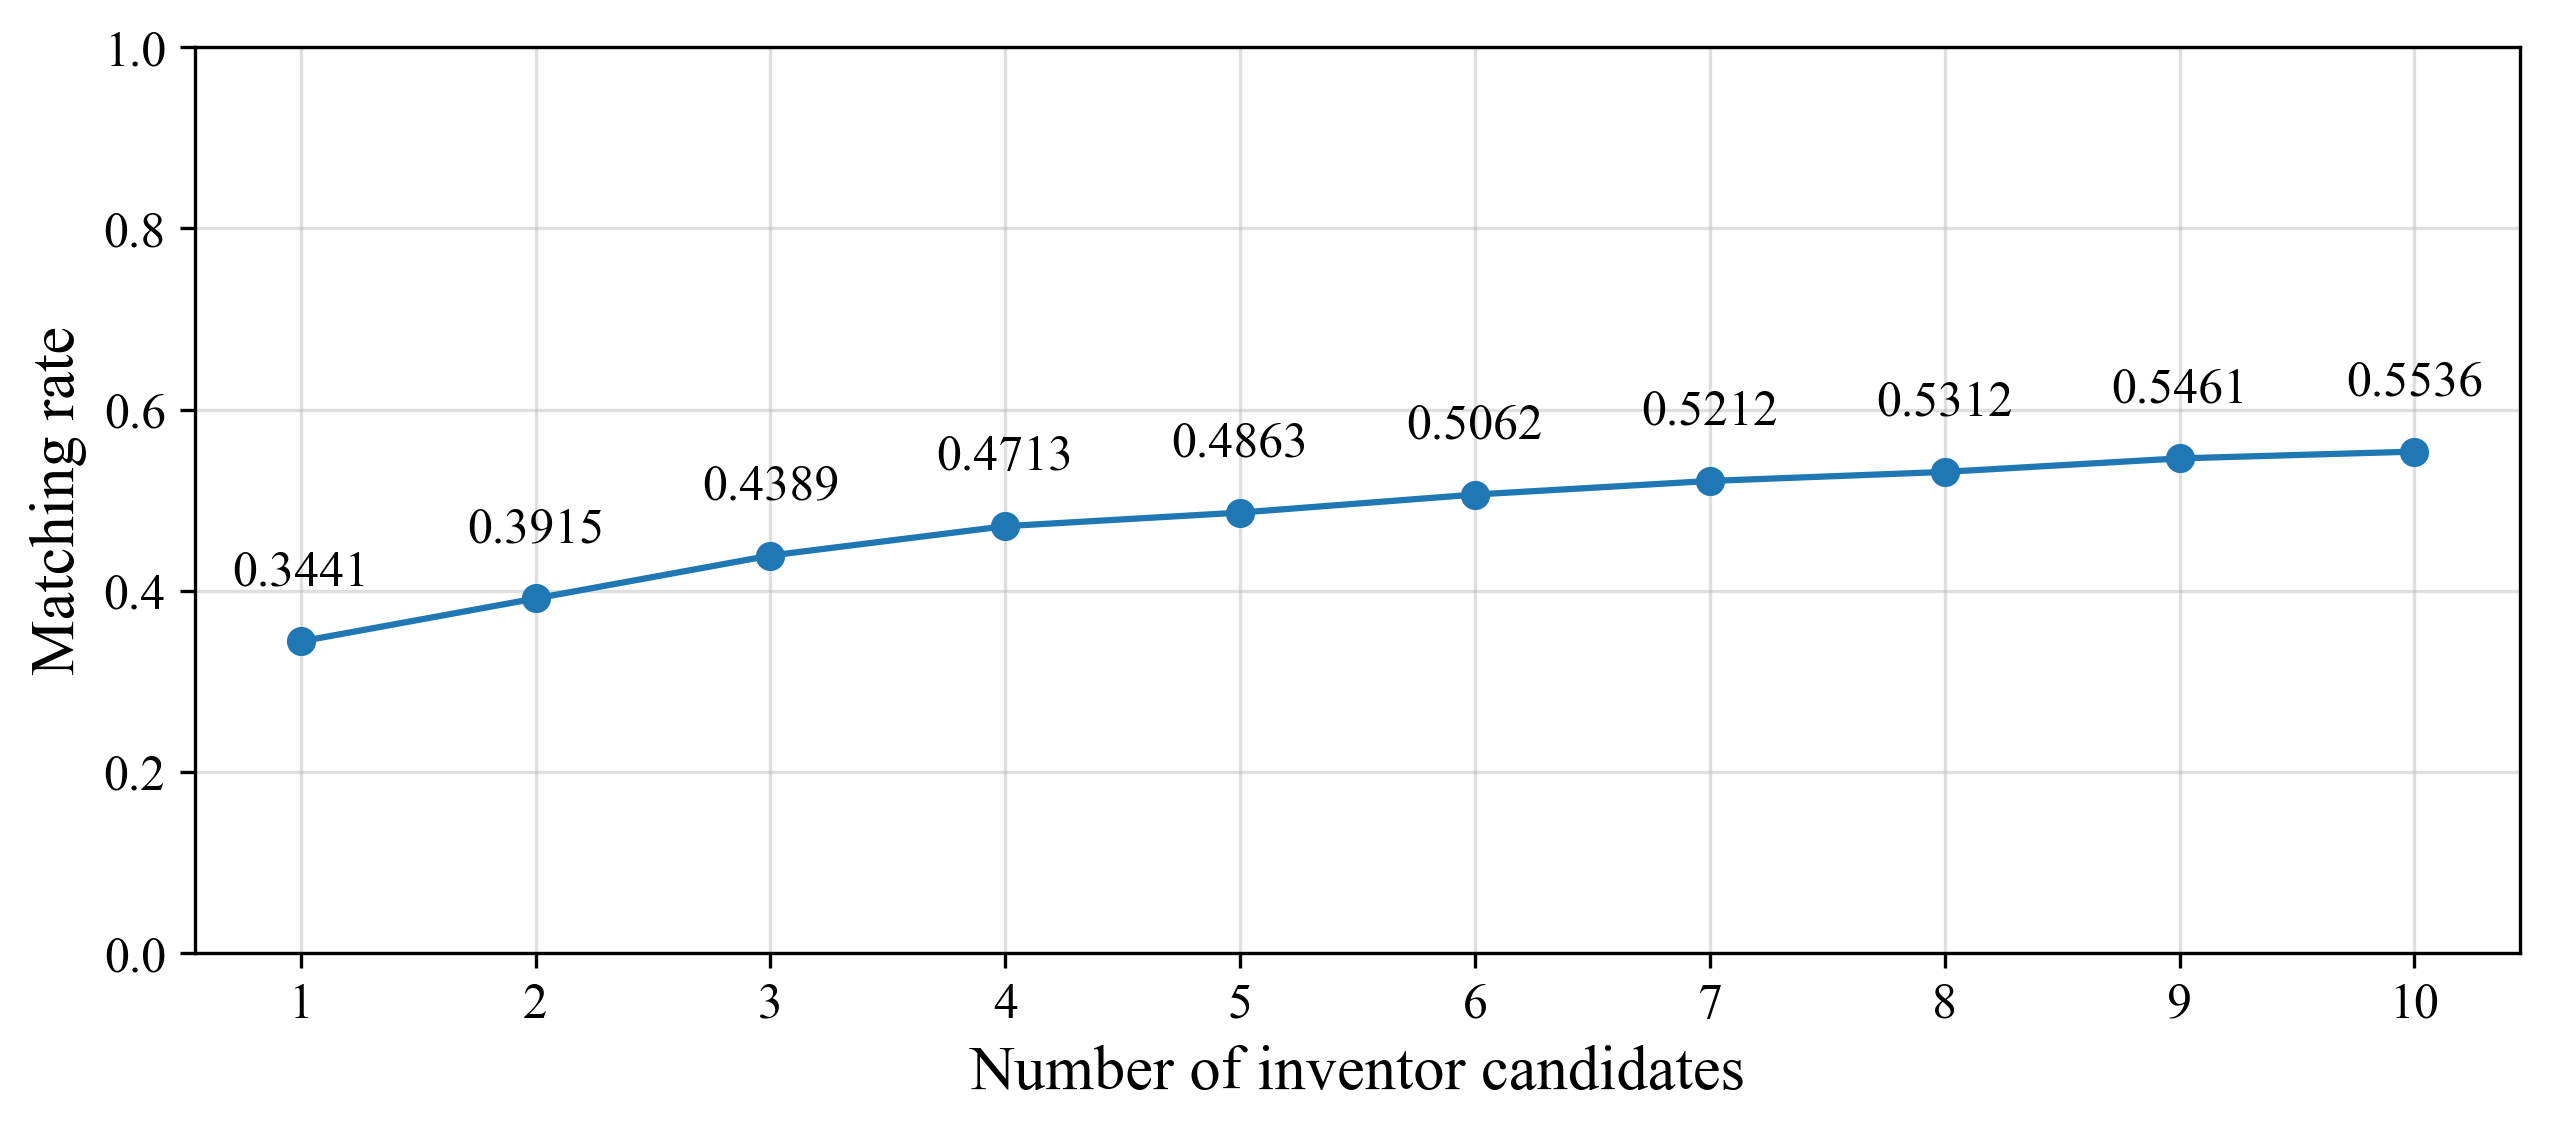

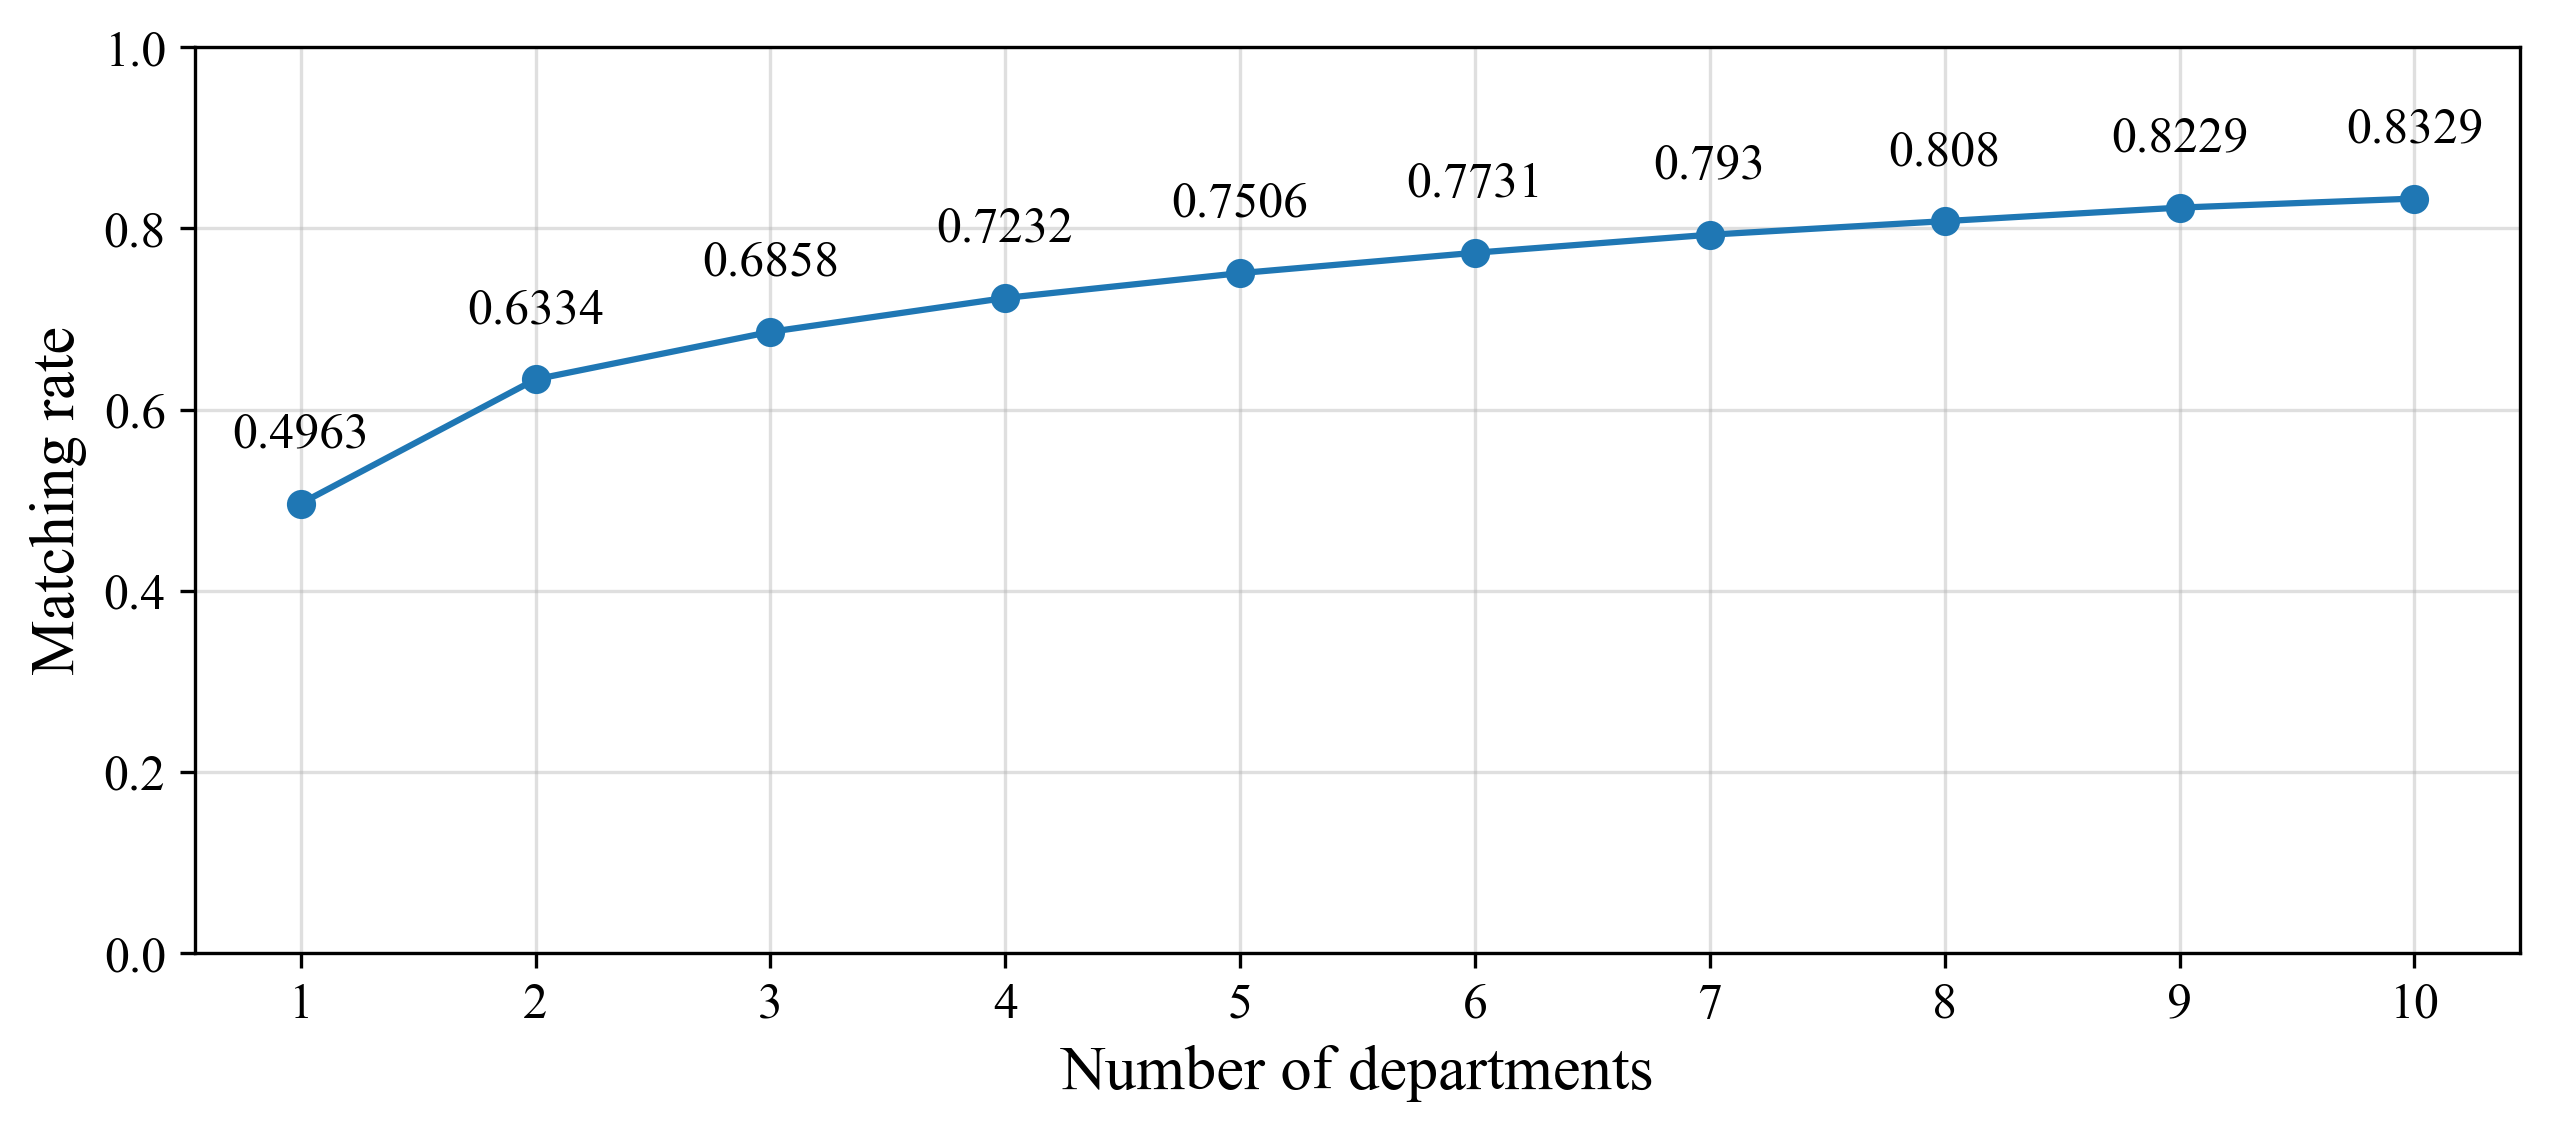

  0%|          | 0/401 [00:00<?, ?it/s]

--------------------------------------------------
For METHOD sif_weight


100%|██████████| 401/401 [00:03<00:00, 121.74it/s]


,0,1,2,3,4,5
0,TITLE_tech,NAME_tech,NAME_IND_tech,DEPART_tech,DEPART_IND_tech,Similarity
1,Prior to the Color Doppler-based technical know-how available on wireless ultrasonic medical dev...,송태경,NAME_279,전자공학전공,DEPART_53,1
2,TITLE_inv,NAME_inv,NAME_IND_inv,DEPART_inv,DEPART_IND_inv,Similarity
0,Method and device for constructing pixel-unit images of photoacoustic and ultrasonic images,장진호,NAME_483,바이오융합기술연구소,DEPART_24,0.4549
0,Image processing methods and devices that perform integrated multi-scale retinex in CIELAB color...,박형민,NAME_237,전자공학전공,DEPART_53,0.4535
0,Development of high-speed/high-definition medical imaging technology,송태경,NAME_279,전자공학전공,DEPART_53,0.453
0,Spectrum detection methods and devices using mutual information volumes in cognitive wireless ne...,소재우,NAME_266,전자공학전공,DEPART_53,0.4526
0,A study on images that can give intensive perception in photo archive exhibition,최용순,NAME_575,영상대학원,DEPART_49,0.4477
0,Prior study for prediction and reduction of plant lead,강성원,NAME_41,기계공학전공,DEPART_14,0.4462
0,Microcalcified tissue detection method using ultrasonic medical imaging device and its ultrasoni...,유양모,NAME_337,전자공학전공,DEPART_53,0.4403


For top 1


100%|██████████| 401/401 [00:00<00:00, 1418.09it/s]


Hit ratio (inventor): 0.3491
Hit ratio (department): 0.5012


For top 2


100%|██████████| 401/401 [00:00<00:00, 1344.52it/s]


Hit ratio (inventor): 0.419
Hit ratio (department): 0.6409


For top 3


100%|██████████| 401/401 [00:00<00:00, 1318.50it/s]


Hit ratio (inventor): 0.4589
Hit ratio (department): 0.6933


For top 4


100%|██████████| 401/401 [00:00<00:00, 1304.95it/s]


Hit ratio (inventor): 0.4888
Hit ratio (department): 0.7207


For top 5


100%|██████████| 401/401 [00:00<00:00, 1279.73it/s]


Hit ratio (inventor): 0.4988
Hit ratio (department): 0.7431


For top 6


100%|██████████| 401/401 [00:00<00:00, 1265.49it/s]


Hit ratio (inventor): 0.5087
Hit ratio (department): 0.7656


For top 7


100%|██████████| 401/401 [00:00<00:00, 1245.40it/s]


Hit ratio (inventor): 0.5312
Hit ratio (department): 0.788


For top 8


100%|██████████| 401/401 [00:00<00:00, 1242.73it/s]


Hit ratio (inventor): 0.5461
Hit ratio (department): 0.803


For top 9


100%|██████████| 401/401 [00:00<00:00, 1220.73it/s]


Hit ratio (inventor): 0.5511
Hit ratio (department): 0.8155


For top 10


100%|██████████| 401/401 [00:00<00:00, 1244.39it/s]


Hit ratio (inventor): 0.5611
Hit ratio (department): 0.8304




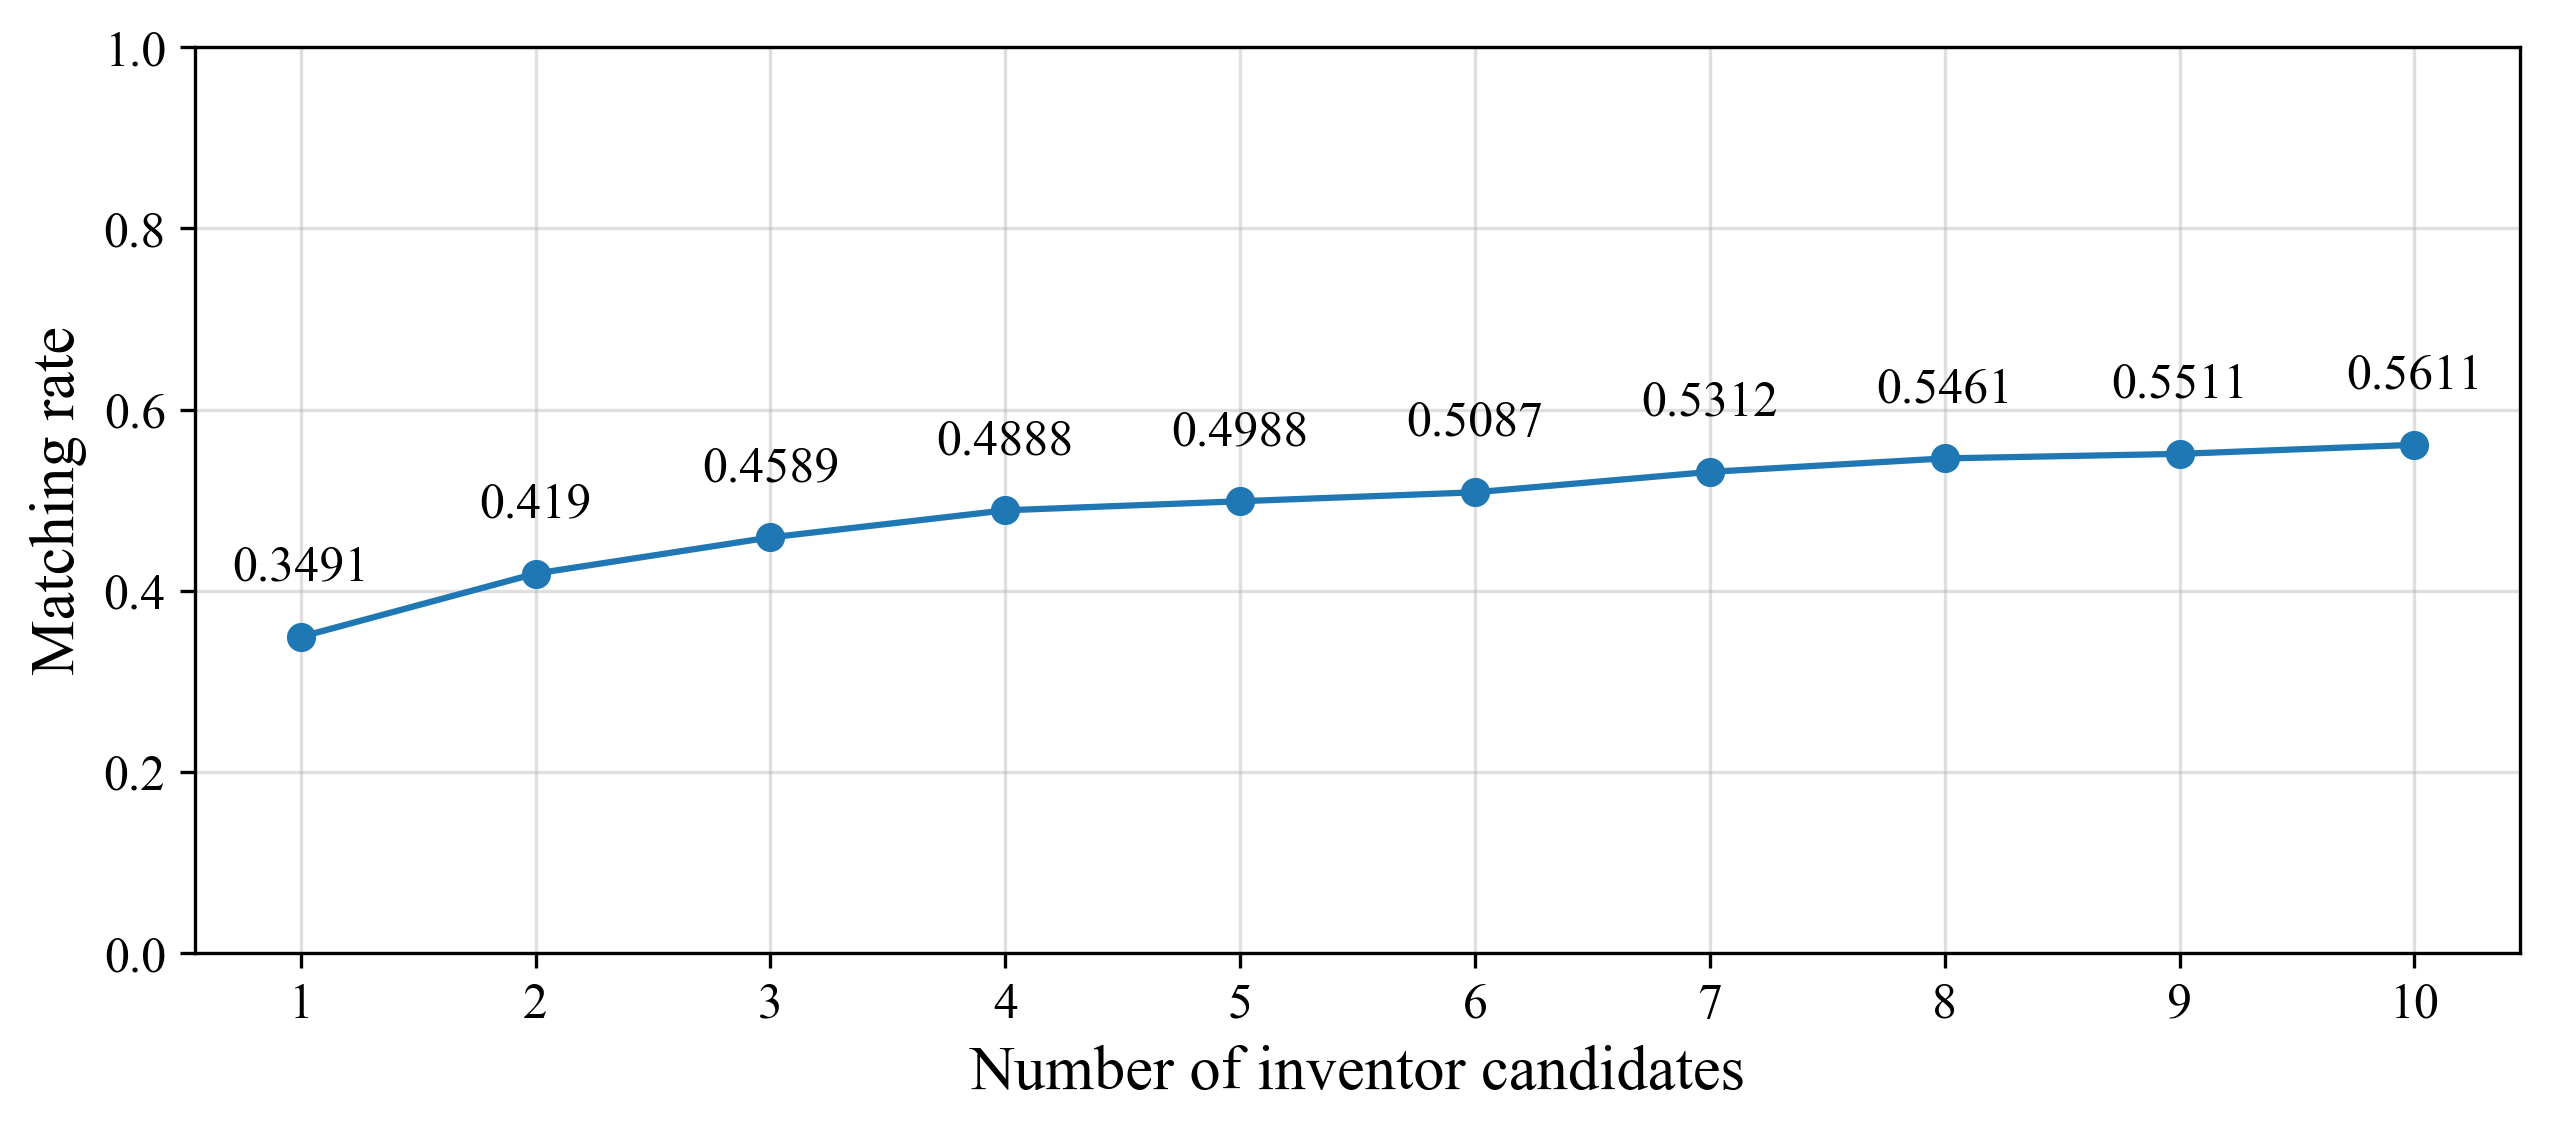

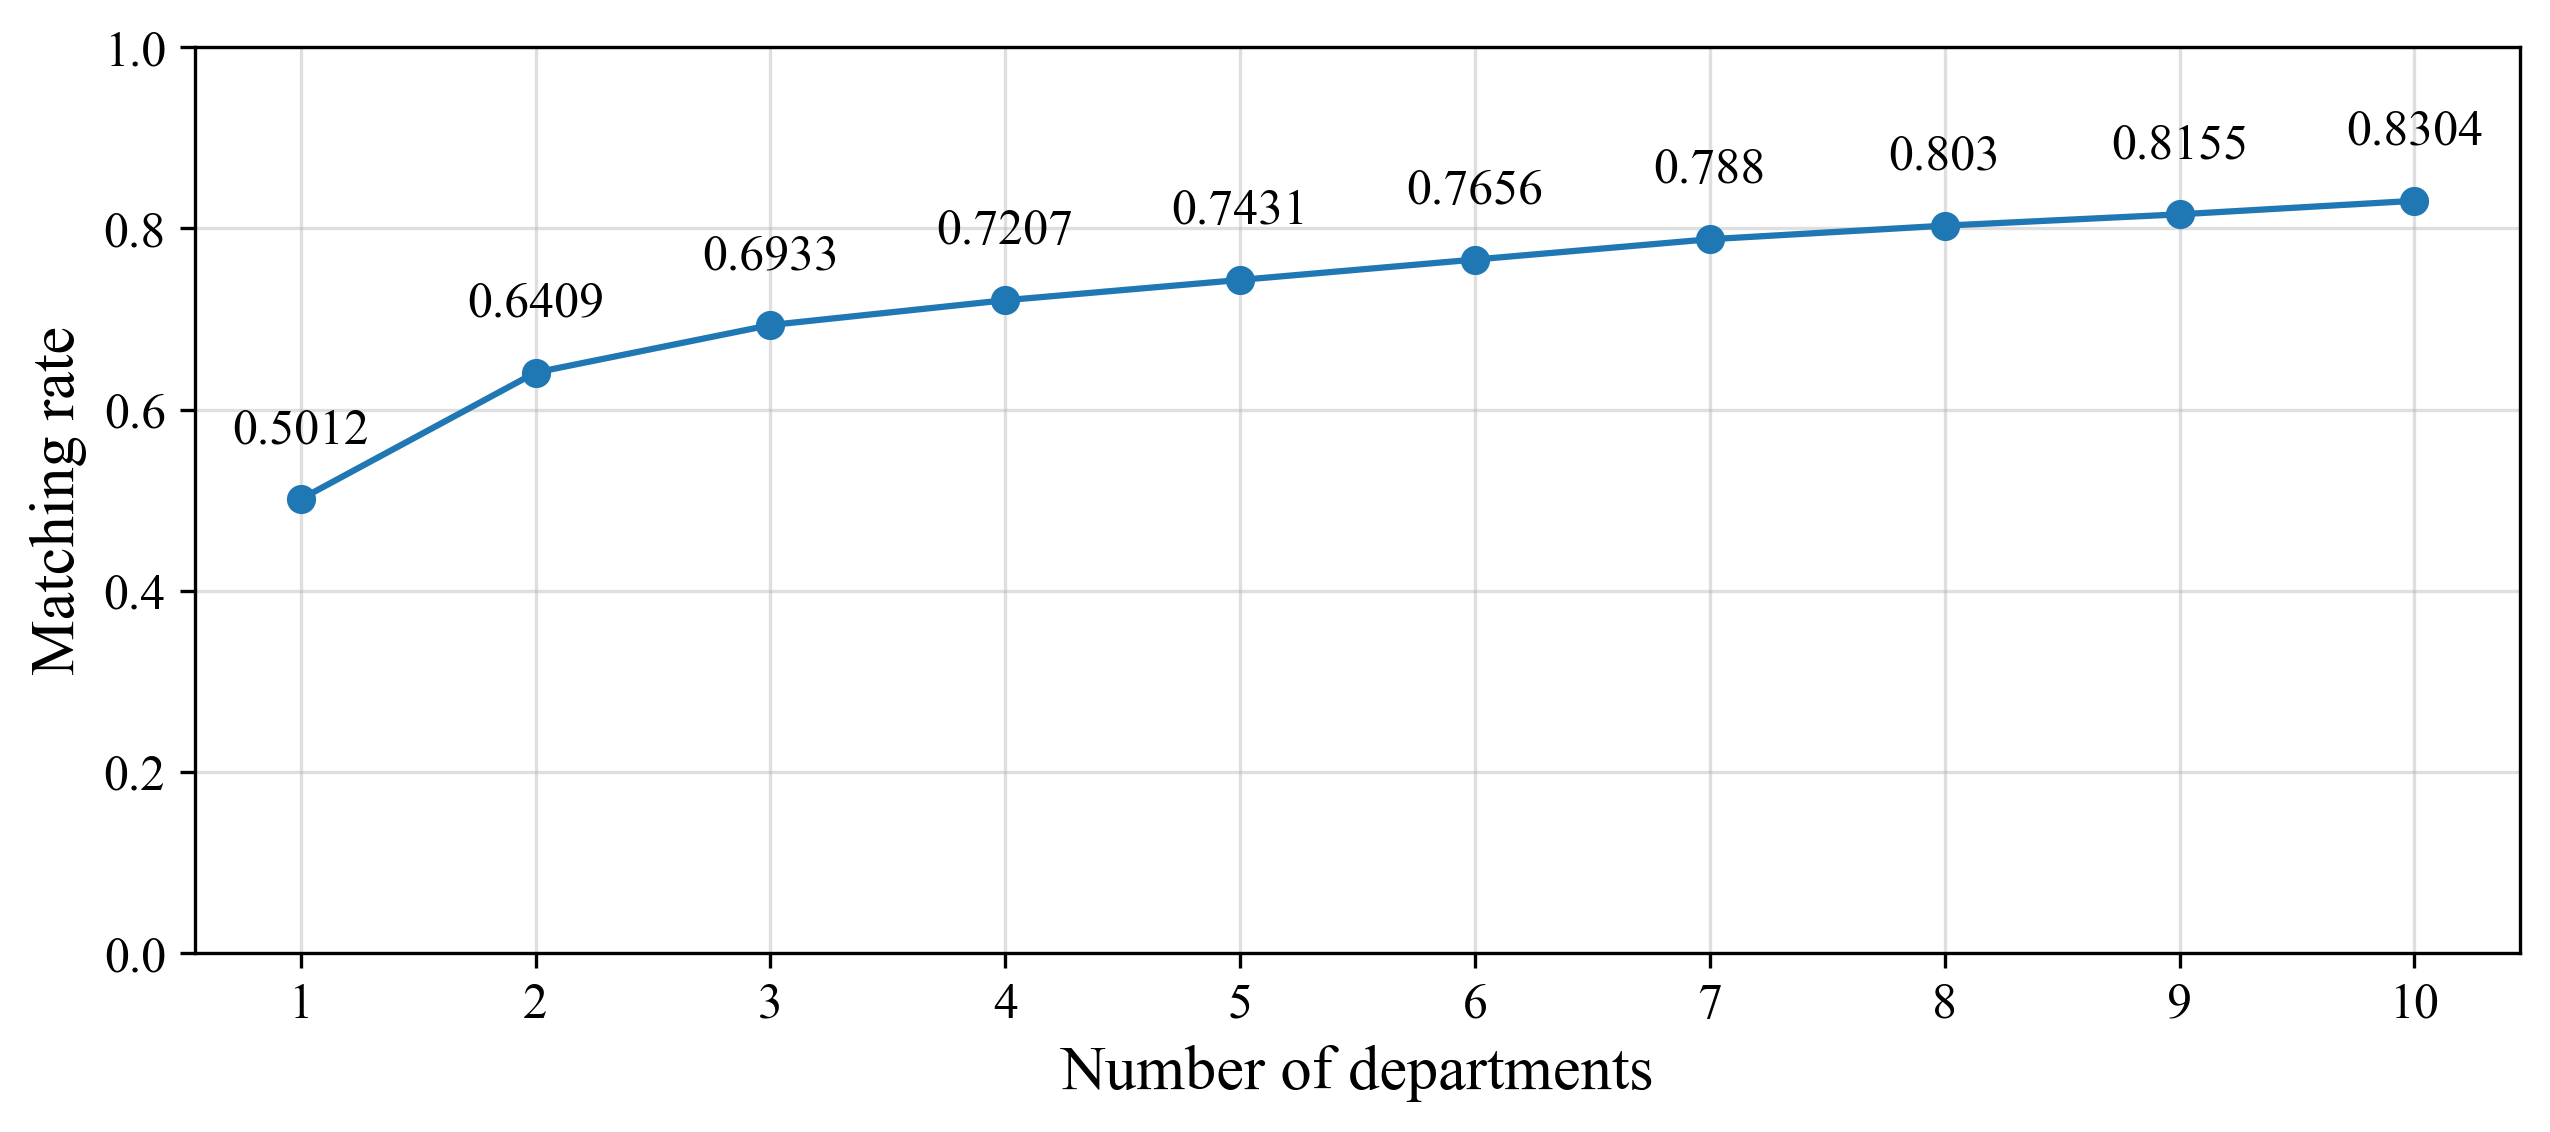

--------------------------------------------------


In [477]:
methods = ['avg', 'sum', 'sif', 'sif_weight']
for method in methods:
    get_result(method=method)